<a href="https://colab.research.google.com/github/NataliaGrasselli/MentoriaChurnPrediction/blob/main/01_Analisis_y_Exploracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiploDatos 2022 - Mentoría "Churn Prediction: ¿Cómo retengo a mis clientes? Machine Learning aplicado a un caso de negocio"

---

#**Integrantes Grupo 2**

*   Natalia Grasselli
*   Rodrigo Pizarro
*   Agustina Quirós
*   Natalia Tassin



# Objetivo:

En este proyecto, desarrollaremos un modelo de aprendizaje automático para ayudar a predecir aquellos clientes que cancelarán la suscripción a una plataforma de streaming de música, y poder con ello implementar alguna estrategia de marketing para retenerlos con anticipación a su posible abandono del servicio.

# Datos

**Conjunto de datos de actividad de los usuarios de [Udacity](https://www.udacity.com/) <br>**

Sparkify es un falso servicio de streaming de música inventado por Udacity. En él, los usuarios pueden escuchar música de forma gratuita (con anuncios entre canciones) o por una tarifa plana. Los usuarios pueden subir, bajar de categoría o cancelar. El objetivo será predecir el usuario que se va a ir para ofrecerle un gran descuento antes de cancelar la suscripción.

El conjunto de datos registra la información demográfica de los usuarios (por ejemplo, nombre del usuario, sexo, estado) y la actividad con la plataforma (por ejemplo, canción escuchada, tipo de evento, dispositivo utilizado) en marcas de tiempo individuales.

Estos datos se utilizarán para el análisis y el entrenamiento del modelo:

[mini_sparkify_event_data.zip](https://github.com/yaninaiberra/DiploDatos2022MentoriaChurnCasoDeNegocio/blob/main/data/raw/mini_sparkify_event_data.zip)

El cual contiene zipeados 543705 registros de actividad de usuarios de con la plataforma de streaming de música.

# Churn: Significado y ¿Para Qué Sirve?

Churn o churn rate hacen referencia a la tasa de abandono o rotación de clientes en una empresa o institución, durante un período de tiempo específico. Es un potente indicador de lealtad y del grado de satisfacción del cliente, que se puede monitorear con la frecuencia que mejor se adapte a las necesidades de tu sector (trimestral, mensual o a diario).

¿Para qué te sirve medir el customer churn? Funciona como un termómetro de la salud de tu negocio: al relevar la fluctuación de clientes brinda información acerca de los índices de satisfacción y, por extensión, predecir el riesgo de abandono.

In [ ]:
import pandas as pd
import seaborn as sns
sns.set_context('talk')
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (20,3)
import missingno as msno

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from IPython.display import HTML

%matplotlib inline

pd.set_option('display.max_rows', 5000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("talk", font_scale = .5, rc={"grid.linewidth": 0.6})

<Figure size 432x288 with 0 Axes>

# 1. Familiarización con el dataset





## Punto a. Importar y analizar el dataset 

 *Importar y analizar el dataset para ver con qué datos contamos, en cantidad y calidad: indagar no sólo el tipo de cada dato (categóricos, numéricos) si no
su naturaleza (si son demográficos, económicos, información personal de los
clientes, etc).

### Importar y Leer el Dataset

Vamos a leer el archivo desde drive.  Se abrirá una ventana pidiendo permisos para que Colab acceda al drive. El archivo 'mini_sparkify_event_data.json' está subido al drive del mentor, con permisos de lector para cualquiera que tenga el link, cuyo código es: '1KzbDj-C6KRrCu4WYFx0e3n_5gOSQFeDe'

Link: https://drive.google.com/file/d/1KzbDj-C6KRrCu4WYFx0e3n_5gOSQFeDe/view?usp=sharing

In [ ]:
# Al ejecutar el código, se mostrará una ventana solicitando permisos de acceso a Drive con la cuenta de correo (personal)
# se deben aceptar los permisos para poder acceder al archivo compartido que contiene el dataset a trabajar

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(filename)

def read_json_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_json(filename, lines=True)

drive = connect_to_drive()
clients_activity_raw = read_json_from_drive(drive, '1KzbDj-C6KRrCu4WYFx0e3n_5gOSQFeDe' , 'mini_sparkify_event_data.json')

Relizamos una copia del dataframe que contiene los datos, para no pisar el original, suele ser una buena práctica.

In [ ]:
#Observamos la forma del df y sus primeras columnas
clients_activity = clients_activity_raw.copy()

### Analizar la estructura

Vamos a comenzar estudiando la forma del df y observamos sus primeras columnas

In [ ]:
#Checkeamos el tamaño del dataset y visualizamos las primeras filas. 
print(clients_activity.shape)
clients_activity.head()

(543705, 18)


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1532063507000.00,M,Martin Orford,Grand Designs,597.55
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1538069638000.00,M,John Brown's Body,Bulls,380.21
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1535953455000.00,M,Afroman,Because I Got High,202.37
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1535953455000.00,M,NaN,NaN,NaN
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1535931018000.00,F,Lily Allen,Smile (Radio Edit),194.53


Observamos que el dataframe contiene 543.705 registros (filas) y 18 campos (columnas). Cada fila representa una interacción entre un usuario y la app. 

In [ ]:
#Observamos las columnas
clients_activity.columns

Index(['ts', 'userId', 'sessionId', 'page', 'auth', 'method', 'status',
       'level', 'itemInSession', 'location', 'userAgent', 'lastName',
       'firstName', 'registration', 'gender', 'artist', 'song', 'length'],
      dtype='object')

In [ ]:
#Observamos de qué tipo es la información que contiene el df
clients_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             543705 non-null  int64  
 1   userId         543705 non-null  object 
 2   sessionId      543705 non-null  int64  
 3   page           543705 non-null  object 
 4   auth           543705 non-null  object 
 5   method         543705 non-null  object 
 6   status         543705 non-null  int64  
 7   level          543705 non-null  object 
 8   itemInSession  543705 non-null  int64  
 9   location       528005 non-null  object 
 10  userAgent      528005 non-null  object 
 11  lastName       528005 non-null  object 
 12  firstName      528005 non-null  object 
 13  registration   528005 non-null  float64
 14  gender         528005 non-null  object 
 15  artist         432877 non-null  object 
 16  song           432877 non-null  object 
 17  length         432877 non-nul

A partir de ello, podemos observar que los distintos campos del df nos mostrarán:

**Información a nivel de usuario**

Estas columnas contienen datos sobre los usuarios: sus nombres, sexo, ubicación, fecha de registro, navegador y nivel de cuenta (paga o gratuita).
 
- userId (string): user’s id
- firstName (string): user’s first name
- lastName (string): user’s last name
- gender (string): user’s gender, 2 categories (M and F)
- location (string): user’s location
- userAgent (string): agent (browser) used by the user
- registration (int): user’s registration timestamp
- level (string): subscription level, 2 categories (free and paid)


**Información específica del uso de la plataforma**

Muestra cómo interactúa un usuario concreto con el servicio.

- ts (int): timestamp of the log.
- page (string): type of interaction associated with the page (NextSong, Home, Login, Cancellation Confirmation, etc.)
- auth (string): authentication level, 4 categories (Logged In, Logged Out, Cancelled, Guest)
- sessionId (int): a session id
- itemInSession (int): log count in the session item id of song in session
- method (string): HTTP request method, 2 categories (GET and PUT)
- status (int): HTTP status code, 3 categories (200, 307 and 404)

**Información a nivel de canción**

- song (string): song name
- artist (string): artist name
- length (double): song’s length in seconds

Además, podemos distinguir entre variables categóricas y numéricas. 

Las **variables categóricas** permiten clasificar una serie de datos por medio de valores fijos asociados a una cualidad o categoría. Estas pueden a su vez clasificarse en ordinales o nominales. Las **ordinales** son variables tienen categorías naturales ordenadas y no se conocen las distancias entre las categorías; las **nominales**, en cambio, no representan un orden. 

Las **variables numericas**, por su parte, son aquellas que representan números y con ellas se pueden realizar operaciones aritméticas. Dentro de las variables numéricas podemos distinguir entre variables numéricas continuas y discretas. 

In [ ]:
#Observamos los campos que representan variables numéricas
print(clients_activity._get_numeric_data().columns)

clients_activity[clients_activity._get_numeric_data().columns]

Index(['ts', 'sessionId', 'status', 'itemInSession', 'registration', 'length'], dtype='object')


,ts,sessionId,status,itemInSession,registration,length
0,1538352011000,292,200,20,1532063507000.00,597.55
1,1538352025000,97,200,74,1538069638000.00,380.21
2,1538352118000,178,200,184,1535953455000.00,202.37
3,1538352119000,178,307,185,1535953455000.00,NaN
4,1538352124000,245,200,22,1535931018000.00,194.53
...,...,...,...,...,...,...
543700,1543622316000,882,200,165,1536850071000.00,183.51
543701,1543622332000,991,200,145,1537523064000.00,239.62
543702,1543622368000,916,200,31,1536228638000.00,234.97
543703,1543622392000,966,200,36,1535616235000.00,262.06


Podemos decir que los siguientes campos representan variables numericas: 'ts', 'sessionId', 'status', 'itemInSession', 'registration', 'length'

Además, userId es un campo que representa variables numéricas pero que el tipo de dato de python con las que se las guardó es 'string', por lo que  no podemos verlas en el código anterior. 


In [ ]:
clients_activity['userId'][:5]

0    293
1     98
2    179
3    179
4    246
Name: userId, dtype: object

En conclusión, podemos decir las siguientes son **variables numéricas**: 

* ts: timestamp of the log (int)
* sessionId: a session id (int)
* itemInSession: log count in the session item id of song in session (int)
* registration: user’s registration timestamp (float)
* length: song’s length in seconds (float)
* status: HTTP status code, 3 categories (200, 307 and 404) (int)
* userId: user’s id (string)

y que estas otras son **variables categóricas nominales**: 

* level (string): subscription level, 2 categories (free and paid)
* auth (string): authentication level, 4 categories (Logged In, Logged Out, Cancelled, Guest)
* method (string): HTTP request method, 2 categories (GET and PUT)
* page: type of interaction associated with the page (NextSong, Home, Login, Cancellation Confirmation, etc.)
* gender (string): user’s gender, 2 categories (M and F)
* userAgent (string): agent (browser) used by the user
* song (string): song name
* artist (string): artist name
* firstName (string): user’s first name
* lastName (string): user’s last name
* location (string): user’s location

## Punto b: Identificar clientes

¿Tenemos forma de identificar de manera única a cada cliente? ¿Cuántos clientes unicos tenemos en del dataset?



Los clientes se identifican mediante la columna `userId`. Observamos que hay 449 números de usuario diferentes.

In [ ]:
#UsersId únicos
clients_activity.userId.nunique()

449

Si queremos acceder a todas las interacciones que ha realizado un usuario en particular:

In [ ]:
#Accedemos a los registros del usuario 124

clients_activity[clients_activity["userId"] == "124"][:3]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
2783,1538407030000,124,123,Home,Logged In,GET,200,paid,0,"Vineland-Bridgeton, NJ","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Beck,Nicole,1532224335000.00,F,NaN,NaN,NaN
2784,1538407052000,124,123,NextSong,Logged In,PUT,200,paid,1,"Vineland-Bridgeton, NJ","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Beck,Nicole,1532224335000.00,F,2652,Channel Two,328.78
2799,1538407380000,124,123,NextSong,Logged In,PUT,200,paid,2,"Vineland-Bridgeton, NJ","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Beck,Nicole,1532224335000.00,F,Leonard Cohen,I'm Your Man,267.68


Observamos que existen algunos registros para los cuales el valor que asume la columna `userId` corresponde a un string vacio. 

In [ ]:
#Vemos los registros para lo que userId es un string vacio
clients_activity[clients_activity['userId']==''][:3]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
6,1538352148000,,178,Home,Logged Out,GET,200,paid,186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1538352151000,,178,Home,Logged Out,GET,200,paid,187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1538352168000,,178,Home,Logged Out,GET,200,paid,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Queremos ver cómo es la columna 'auth' para estos registros
clients_activity[clients_activity['userId']=='']['auth'].value_counts()

Logged Out    15606
Guest            94
Name: auth, dtype: int64

In [ ]:
#Registros únicos sin contar los Ids vacíos
clients_activity.userId[clients_activity['userId']!=''].nunique()

448

Esto ocurre siempre que la interacción es entre un usuario que ya cerró sesión o uno que ingresó como guest. Por lo que en realidad tenemos 448 usuarios únicos y una serie de registros que no podemos identificarlos con ningun usuario.

## Punto c: Fechas

¿Qué periodos de fechas tenemos en el dataset?

### Columna ts

Observamos que las fechas en las que se realiza cada operación está representada por la columna `'ts'`. Esta columna que indica la fecha y hora de actividad del usuario con la plataforma de música,en formato 'unix timestamp' (milisegundos desde 01/01/1970). 

Para simplificar la lectura de las fechas, vamos a agregar nuevas columnas al dataframe, transformando éste dato `'ts'` a:
- date
- hour
- day
- month
- year


In [ ]:
#Observamos que no hay filas donde ts sea cero

clients_activity[clients_activity['ts']==0]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length


In [ ]:
#Creamos una función que va a crear las nuevas columnas para la lectura de las fechas:

import datetime
import numpy as np

def convert_ts(df, timestamp_column):
  df[timestamp_column] = df[timestamp_column]/1000.0
  df[timestamp_column] = df[timestamp_column].apply(np.int64)
  # unit='s' to convert it into epoch time
  df['date']=pd.to_datetime(df[timestamp_column], unit='s')
  #Convert datetime column/series to hour of the day. NB: Column must be in datetime format.
  df['hour'] = df['date'].dt.hour
  #Convert datetime column/series to day of the week
  df['day'] = df['date'].dt.weekday
  #Convert datetime column/series to month
  df['month'] = df['date'].dt.month
  #Convert datetime column/series to year
  df['year'] = df['date'].dt.year
  return df

In [ ]:
#Creamos un nuevo df a partir de aplicar la función al que ya teníamos

clients_activity_format = convert_ts(df=clients_activity, timestamp_column='ts')

In [ ]:
clients_activity_format.sample(10)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,registration,gender,artist,song,length,date,hour,day,month,year
221977,1541259540,246,2860,NextSong,Logged In,PUT,200,paid,703,"Mobile, AL",...,1535931018000.00,F,Tex Williams,Downtown Poker Club,167.05,2018-11-03 15:39:00,15,5,11,2018
325551,1542555046,98,3938,NextSong,Logged In,PUT,200,paid,83,"Houston-The Woodlands-Sugar Land, TX",...,1538069638000.00,M,Alexi Murdoch,Blue Mind,343.46,2018-11-18 15:30:46,15,6,11,2018
280887,1541934784,223,3355,NextSong,Logged In,PUT,200,paid,1,"Los Angeles-Long Beach-Anaheim, CA",...,1534945722000.00,M,D.L.G.,Acuyuye,292.57,2018-11-11 11:13:04,11,6,11,2018
177541,1540790439,276,2606,NextSong,Logged In,PUT,200,paid,88,"Phoenix-Mesa-Scottsdale, AZ",...,1536977188000.00,M,Common / Bilal,Aquarius,319.71,2018-10-29 05:20:39,5,0,10,2018
266263,1541748070,238,3329,Home,Logged In,GET,200,paid,195,"Miami-Fort Lauderdale-West Palm Beach, FL",...,1532692552000.00,M,NaN,NaN,NaN,2018-11-09 07:21:10,7,4,11,2018
20176,1538640863,100,706,NextSong,Logged In,PUT,200,paid,277,"Dallas-Fort Worth-Arlington, TX",...,1537982255000.00,M,Daniel Licht,Blood Theme,146.36,2018-10-04 08:14:23,8,3,10,2018
43702,1539046145,214,849,NextSong,Logged In,PUT,200,paid,14,"Show Low, AZ",...,1535231759000.00,M,Hello Saferide,The Quiz,135.84,2018-10-09 00:49:05,0,1,10,2018
540827,1543450141,300002,914,NextSong,Logged In,PUT,200,paid,138,"Truckee-Grass Valley, CA",...,1532589384000.00,F,Fuel,Shimmer,214.07,2018-11-29 00:09:01,0,3,11,2018
531751,1542737585,300049,843,NextSong,Logged In,PUT,200,paid,1,"Fresno, CA",...,1537523064000.00,M,Patty Griffin,Top of the World,328.72,2018-11-20 18:13:05,18,1,11,2018
147184,1540387942,291,2237,NextSong,Logged In,PUT,200,paid,60,"Killeen-Temple, TX",...,1531747953000.00,M,DJ Dizzy,Sexy Bitch,221.15,2018-10-24 13:32:22,13,2,10,2018


### Período de tiempo

A partir de estas transformaciones, podemos calcular cuál es el período de tiempo que representa nuestro dataset:

In [ ]:
#Calculamos fecha mínima y fecha máxima que figura en el df
clients_activity_format['date'].min(), clients_activity_format['date'].max()

(Timestamp('2018-10-01 00:00:11'), Timestamp('2018-12-01 00:01:06'))

Observamos que el dataset representa interacciones ocurridas entre el 1ero de octubre del 2018 y el 1ero de diciembre de ese mismo año. Es decir, representa sólo dos meses de interacciones con los usuarios.

## Punto d: Datos nulos y suficiencia de datos

¿Tenemos datos nulos? Pensando en el histórico de datos, ¿tenemos datos "suficientes" para pensar en realizar un modelo predictivo?

In [ ]:
#Observamos cuáles son las columnas que tienen datos nulos
clients_activity_format.isnull().sum()

ts                    0
userId                0
sessionId             0
page                  0
auth                  0
method                0
status                0
level                 0
itemInSession         0
location          15700
userAgent         15700
lastName          15700
firstName         15700
registration      15700
gender            15700
artist           110828
song             110828
length           110828
date                  0
hour                  0
day                   0
month                 0
year                  0
dtype: int64

Text(0.5, 1.0, 'Visualización de Datos Nulos')

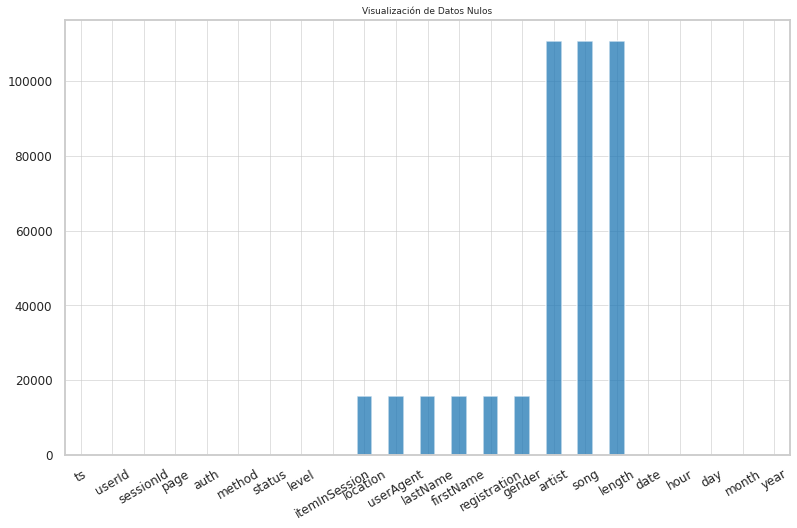

In [ ]:
#Visualizamos la cantidad de datos nulos
clients_activity_format.isna().sum().plot(kind='bar', rot=30, alpha=0.75, fontsize=12, figsize=(13,8)).set_title("Visualización de Datos Nulos")

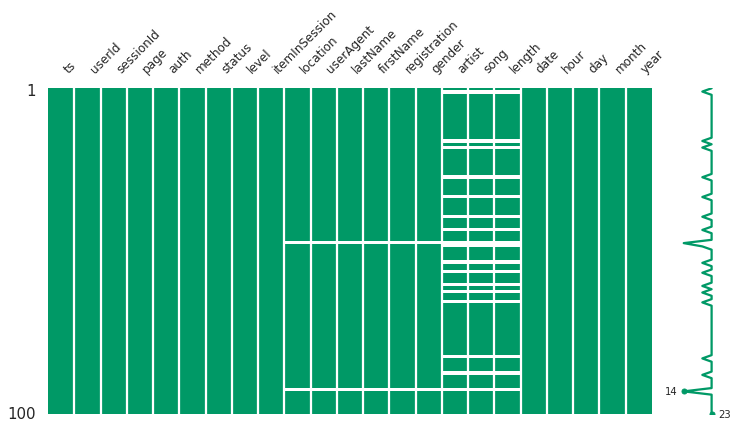

In [ ]:
#Observamos si los datos faltantes tienen alguna relación entre ellos

msno.matrix(clients_activity_format.sample(100),figsize=(12, 6), fontsize=12, color=[0,0.6,0.4])

De los gráficos anteriores se puede ver que hay una cierta cantidad de datos nulos relacionados en "bloque" a nivel 'usuario' (15700 datos) que corresponden a las columnas de location, userAgent, lastName, firstName, registration y gender. 

Por otro lado, existen también datos nulos que irían "en bloque" a nivel 'artista/canción' (110828 datos) correspondientes específicamente a las columnas de artist, song y lenght.



### Valores nulos referidos a las canciones

Observamos que hay una serie de valores nulos relacionados a las canciones. 

In [ ]:
#Observamos las columnas para las que 'song' es nulo
clients_activity_format[clients_activity_format["song"].isnull()][:5]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,registration,gender,artist,song,length,date,hour,day,month,year
3,1538352119,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL",...,1535953455000.00,M,NaN,NaN,NaN,2018-10-01 00:01:59,0,0,10,2018
6,1538352148,,178,Home,Logged Out,GET,200,paid,186,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:02:28,0,0,10,2018
7,1538352151,,178,Home,Logged Out,GET,200,paid,187,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:02:31,0,0,10,2018
8,1538352168,,178,Home,Logged Out,GET,200,paid,188,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:02:48,0,0,10,2018
9,1538352169,,178,Login,Logged Out,PUT,307,paid,189,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:02:49,0,0,10,2018


In [ ]:
#Queremos ver qué valores toma 'page' cuando 'song' es nulo 
clients_activity_format[clients_activity_format['song'].isna()]['page'].value_counts()

Home                         27412
Thumbs Up                    23826
Add to Playlist              12349
Add Friend                    8087
Roll Advert                   7773
Login                         6011
Logout                        5990
Thumbs Down                   4911
Downgrade                     3811
Help                          3150
Settings                      2964
About                         1855
Upgrade                        968
Save Settings                  585
Error                          519
Submit Upgrade                 287
Submit Downgrade               117
Cancel                          99
Cancellation Confirmation       99
Register                        11
Submit Registration              4
Name: page, dtype: int64

In [ ]:
#Queremos ver qué valores toma 'page' cuando 'song' NO es nulo
clients_activity_format[~clients_activity_format['song'].isna()]['page'].value_counts()

NextSong    432877
Name: page, dtype: int64

Observamos que cuando `'song'` tiene un valor nulo, entonces siempre tendremos valores nulos en `'artist'` y `'lenght'` también (como se vio en las gráficas anteriores). 

Además, los valores nulos para estas 3 variables ocurren cada vez que la interacción NO corresponde a una acción del tipo 'next song' en la columna `'page'`

### Valores nulos referidos a la identificación de usuario

Por otro lado, hay una serie de valores nulos referidos a la identificación del usuario. 

In [ ]:
#Observamos las columnas para las que 'userAgent' es nulo
clients_activity_format[clients_activity_format["userAgent"].isnull()][:5]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,registration,gender,artist,song,length,date,hour,day,month,year
6,1538352148,,178,Home,Logged Out,GET,200,paid,186,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:02:28,0,0,10,2018
7,1538352151,,178,Home,Logged Out,GET,200,paid,187,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:02:31,0,0,10,2018
8,1538352168,,178,Home,Logged Out,GET,200,paid,188,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:02:48,0,0,10,2018
9,1538352169,,178,Login,Logged Out,PUT,307,paid,189,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:02:49,0,0,10,2018
70,1538353292,,442,Home,Logged Out,GET,200,free,114,NaN,...,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:21:32,0,0,10,2018


In [ ]:
#Queremos ver qué valores toma 'auth' cuando 'userAgent' es nulo
clients_activity_format[clients_activity_format['userAgent'].isna()]['auth'].value_counts()

Logged Out    15606
Guest            94
Name: auth, dtype: int64

In [ ]:
#Queeremos ver qué valores toma 'page' cuando 'userAgent' es nulo
clients_activity_format[clients_activity_format['userAgent'].isna()]['page'].value_counts()

Home                   8323
Login                  6011
About                   829
Help                    506
Error                    16
Register                 11
Submit Registration       4
Name: page, dtype: int64

Se puede ver que los campos `location`, `userAgent`, `lastName`, `firstName`, `registration` y `gender` son nulos sólo en los casos donde el usuario *no está logeado* en la página (15606 eventos) o ingresa como guest (94 eventos). 

En conclusión, es lógico que aquí los valores sean nulos, ya que no podemos identificar ese registro con un `userId` en particular.
********************************************************************************

Como mencionamos antes, hay una serie de registros para los que `userId` es un string vacio. Esto no figura como Nan, por que en realidad esa celda si tiene un valor (''); por lo tanto, no nos figura cuando buscamos los NaN values del df. 

Particularmente, los registros del df para los cuales `userId` es un string vacio, coinciden con los valores para los cuales las columnas mencionadas anteriormente son nulas.

In [ ]:
#La intersección entre 'userId' identificado y 'userAgent' nulo es vacía
clients_activity_format[(clients_activity_format['userId'] !='') & (clients_activity_format['userAgent'].isna())]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,registration,gender,artist,song,length,date,hour,day,month,year


In [ ]:
#La intersección entre 'userId' no identificado y 'userAgent' no nulo es vacía
clients_activity_format[(clients_activity_format['userId'] =='') & (~clients_activity_format['userAgent'].isna())]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,registration,gender,artist,song,length,date,hour,day,month,year


Con las intersecciones anteriores se puede concluir que en el data set estudiado, no hay casos donde `userId` no esté identificado y `userAgent` sea no nulo, o viceversa, es decir donde `userAgent` sea nulo y el `userId` esté identificado.

### Suficiencia de los datos

Con la información relevada y analizada hasta el momento sabemos que:

- tenemos 543705 registros
- los registros corresponden a 2 meses de datos
- tenemos 449 clientes diferentes identificados con un código único

Con sólo ésta información no podemos afirmar aún la **'suficiencia o insuficiencia'** de los datos. 

Si bien tenemos más de 500k de registros, sólo se corresponden a dos meses de histórico (1ero de octubre del 2018 y el 1ero de diciembre de ese mismo año) y puede haber cierta estacionalidad en ese período, o no tener la suficiente cantidad de clientes diferentes representados para identificar patrones de perfiles o de comportamientos y en consecuencia, un cliente nuevo puede "no parecerse" a ninguno de los existentes y por lo tanto es posible obtener predicciones poco confiables.

Se continuará con el análisis del dataset y cuando lleguemos a la parte de realizar modelos predictivos, veremos si con la información disponible logramos un buen modelo (existen métricas para evaluar cuán buenos son los modelos de clasificación, en éste caso).

En este sentido, nos parece importante resaltar que pensamos que los datos podrían utilizarse para hacer predicciones para el corto plazo posterior al primero de diciembre. Por ejemplo, para predecir churn en diciembre del 2018 o enero 2019; pero que no necesariamente va a ser adecuado para predecir churn en la actualidad (año 2022), ya que tanto el comportamiento del consumidor como los atributos de la aplicación podrían haber cambiado en el transcurso de este tiempo, afectando la capacidad de nuestro modelo de predecir adecuadamente. 
********************************************************************************

## Punto e: Columna Target

¿Tenemos la columna target (necesaria en problemas de aprendizaje supervisado de clasificación)? ¿Cómo podemos definir "Churn" para éste dataset? 


No contamos en el dataset con una columna que nos indique si el cliente ha aandonado el servicio o no, y de hecho hay varias formas de definirlo:

- Predecir cuándo un usuario abandonará el servicio, definido mediante la acción 'Cancellation Confirmation' de un usuario determinado.
- Predecir cuándo un usuario pago bajará de categoría al servicio gratuito, definido por la acción 'Submit Downgrade'.
- Una combinación de ambas acciones.

La definición de "Churn" por parte de un usuario o cliente, suele venir dada por la empresa que provee los datos y quiere buscar con Ciencia de Datos ayuda para esa "fuga" de clientes.
Encarar la solución con una u otra de las tres definiciones posibles, representará tres caminos diferentes, tres enfoques de predicción diferente, ya que estaremos prediciendo justamente tres situaciones distintas.

In [ ]:
# Veamos los posibles valores de 'page'
clients_activity_format['page'].value_counts()

NextSong                     432877
Home                          27412
Thumbs Up                     23826
Add to Playlist               12349
Add Friend                     8087
Roll Advert                    7773
Login                          6011
Logout                         5990
Thumbs Down                    4911
Downgrade                      3811
Help                           3150
Settings                       2964
About                          1855
Upgrade                         968
Save Settings                   585
Error                           519
Submit Upgrade                  287
Submit Downgrade                117
Cancel                           99
Cancellation Confirmation        99
Register                         11
Submit Registration               4
Name: page, dtype: int64

### **Nuestra Definición de Churn**

Se consideró que los usuarios que se dieron de baja del servicio premium pero continuan utilizando la aplicación, siguen siendo importantes para el negocio, ya que al consumir publicidad siguen generando valor para la empresa. Es por esto que se considera solamente la acción `"Cancellation Confirmation"` como churn.


### Columna churn_action

Para hacer esto, se decidió agregar al df un campo `churn_action` booleano, que va a tomar el valor True solo para los registros donde la columna 'page' sea `"Cancellation Confirmation"`. 

Es decir esta columna marca como **True** únicamente al registro donde se efectúa la acción de **confirmar la cancelación al servicio**.

In [ ]:
#Trabajamos sobre una copia del df anterior:
clients_activity_churn = clients_activity_format.copy()

In [ ]:
#Agregamos la columna churn_action
clients_activity_churn['churn_action'] = np.where(clients_activity_churn['page'] == 'Cancellation Confirmation', True, False)

In [ ]:
#Chequeamos que se hayan marcado como True los casos de churn "Cancellation Confirmation"
clients_activity_churn[clients_activity_churn['page']=='Cancellation Confirmation'][['userId','page','churn_action']].head()

,userId,page,churn_action
2555,208,Cancellation Confirmation,True
6758,231,Cancellation Confirmation,True
12652,236,Cancellation Confirmation,True
16350,156,Cancellation Confirmation,True
29338,271,Cancellation Confirmation,True


### Columna target: churn_user

Observamos que así, un mismo usuario tendrá posiblemente False y True, ya que la nueva columna sólo nos marca la acción churn y no al usuario que alguna vez lo hizo. 

In [ ]:
# Un mismo usuario tendrá posiblemente 0 y 1
clients_activity_churn[clients_activity_churn['userId']=='208'][['userId','page','churn_action']].tail()

,userId,page,churn_action
2540,208,Add Friend,False
2549,208,NextSong,False
2553,208,Settings,False
2554,208,Cancel,False
2555,208,Cancellation Confirmation,True


In [ ]:
#Observamos cuáles son los clientes para los que alguna vez ocurrió la acción 'churn'
clients_activity_churn[clients_activity_churn.page == "Cancellation Confirmation"]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,gender,artist,song,length,date,hour,day,month,year,churn_action
2555,1538400616,208,490,Cancellation Confirmation,Cancelled,GET,200,free,40,"Fort Wayne, IN",...,F,NaN,NaN,NaN,2018-10-01 13:30:16,13,0,10,2018,True
6758,1538482793,231,471,Cancellation Confirmation,Cancelled,GET,200,paid,234,"Columbus, OH",...,F,NaN,NaN,NaN,2018-10-02 12:19:53,12,1,10,2018,True
12652,1538539871,236,682,Cancellation Confirmation,Cancelled,GET,200,paid,109,"Grand Rapids-Wyoming, MI",...,M,NaN,NaN,NaN,2018-10-03 04:11:11,4,2,10,2018,True
16350,1538592529,156,628,Cancellation Confirmation,Cancelled,GET,200,free,66,"Bowling Green, KY",...,M,NaN,NaN,NaN,2018-10-03 18:48:49,18,2,10,2018,True
29338,1538770077,271,395,Cancellation Confirmation,Cancelled,GET,200,paid,227,"Roanoke, VA",...,M,NaN,NaN,NaN,2018-10-05 20:07:57,20,4,10,2018,True
31179,1538800531,200,862,Cancellation Confirmation,Cancelled,GET,200,paid,193,"Seattle-Tacoma-Bellevue, WA",...,M,NaN,NaN,NaN,2018-10-06 04:35:31,4,5,10,2018,True
35204,1538890895,130,1027,Cancellation Confirmation,Cancelled,GET,200,free,9,"Bridgeport-Stamford-Norwalk, CT",...,M,NaN,NaN,NaN,2018-10-07 05:41:35,5,6,10,2018,True
36252,1538959081,123,480,Cancellation Confirmation,Cancelled,GET,200,free,56,"Tampa-St. Petersburg-Clearwater, FL",...,M,NaN,NaN,NaN,2018-10-08 00:38:01,0,0,10,2018,True
37670,1538987586,54,1010,Cancellation Confirmation,Cancelled,GET,200,paid,7,"Spokane-Spokane Valley, WA",...,F,NaN,NaN,NaN,2018-10-08 08:33:06,8,0,10,2018,True
39903,1539011456,39,1066,Cancellation Confirmation,Cancelled,GET,200,paid,82,"Los Angeles-Long Beach-Anaheim, CA",...,F,NaN,NaN,NaN,2018-10-08 15:10:56,15,0,10,2018,True


In [ ]:
# Veamos cuántos usuarios hay con 'churn_action' = True
userId_churn_cancellation =list(clients_activity_churn[clients_activity_churn['churn_action']==True]['userId'].unique())
len(userId_churn_cancellation) # Hay 99 usuarios que alguna vez pasaron por la página de Confirmación de Cancelación

99

Entonces, vamos a crear una columna que llamaremos 'churn_user' que nos indique con un 1 si un usuario hizo churn en algún momento y con un 0 si nunca lo hizo. 

In [ ]:
# Agregamos la nueva columna churn_user
clients_activity_churn['churn_user'] = np.where(clients_activity_churn['userId'].isin(userId_churn_cancellation), 1, 0)

In [ ]:
#El usuario tendrá ahora en todas sus filas la marca de churn_user = 1, porque alguna vez pasó por la página de Confirmación de Cancelación:
clients_activity_churn[clients_activity_churn['userId']=='208'][['userId','date','level','churn_action','churn_user']].tail()

,userId,date,level,churn_action,churn_user
2540,208,2018-10-01 13:25:50,free,False,1
2549,208,2018-10-01 13:29:10,free,False,1
2553,208,2018-10-01 13:30:08,free,False,1
2554,208,2018-10-01 13:30:09,free,False,1
2555,208,2018-10-01 13:30:16,free,True,1


In [ ]:
#Queremos ver los registros 'churn' vs 'no churn'
clients_activity_churn['churn_user'].value_counts()

0    440059
1    103646
Name: churn_user, dtype: int64

Agrupamos los eventos churn vs no churn por 'userId' para contar la cantidad de usuarios 'churn' vs la cantidad de usuarios 'no churn' en nuestro dataset:

In [ ]:
#Cantidad de usuarios churn vs no churn
clients_activity_churn.groupby('userId', as_index=False).agg({'churn_user': 'first'})['churn_user'].value_counts()

0    350
1     99
Name: churn_user, dtype: int64

**Hay 350 usuarios que nunca hicieron churn y 99 usuarios que alguna vez hicieron churn en el período de tiempo analizado**

In [ ]:
#Guardamos los datos en un archivo csv
clients_activity_churn.to_csv('sparkify_data_churn_labeled.csv', index=False)

# 2. Análisis y Visualización de los datos

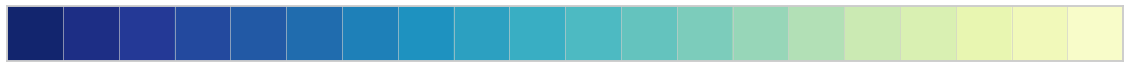

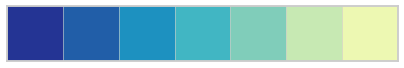

In [ ]:
#Como a continuación vamos a usar muchos gráficos, seteamos la paleta de colores

big_palette = sns.color_palette("YlGnBu_r", 20)
sns.palplot(big_palette)

small_palette = sns.color_palette("YlGnBu_r", 7)
sns.palplot(small_palette)

color_churn = small_palette[4]
color_no_churn = small_palette[2]

#palette = [BrBG[6],BrBG[3]]

## Punto a: Análisis datos numéricos

Para los datos numéricos, realizar una breve descripción de resumen estadísticos, para comprender los rangos (mín, max, media, moda, quantiles).

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # sacamos notación científica
clients_activity_churn.describe()

,ts,sessionId,status,itemInSession,registration,length,hour,day,month,year,churn_user
count,543705.000,543705.000,543705.000,543705.000,528005.000,432877.000,543705.000,543705.000,543705.000,543705.000,543705.000
mean,1540964541.210,2040.814,210.018,107.306,1535523414862.102,248.665,12.223,2.646,10.491,2018.000,0.191
std,1482057.145,1434.339,31.472,116.724,3078725492.995,98.413,6.905,1.825,0.500,0.000,0.393
min,1538352011.000,1.000,200.000,0.000,1509854193000.000,0.783,0.000,0.000,10.000,2018.000,0.000
25%,1539720148.000,630.000,200.000,26.000,1534367797000.000,199.392,6.000,1.000,10.000,2018.000,0.000
50%,1541004718.000,1968.000,200.000,68.000,1536555881000.000,234.004,13.000,3.000,10.000,2018.000,0.000
75%,1542176550.000,3307.000,200.000,147.000,1537611935000.000,276.793,18.000,4.000,11.000,2018.000,0.000
max,1543622466.000,4808.000,404.000,1005.000,1543073874000.000,3024.666,23.000,6.000,12.000,2018.000,1.000


Como features interesantes para utilizar estos estadisticos, podemos encontrar:

 - **lenght**: Se ve que la media de las duraciones es de 248.664593 y se encuentra levemente por encima de le mediana. También se pueden encontrar algúnos valores extremos, tanto superiores como inferiores. La unidad en la que se mide esta longitud es segundos, aunque se pueden ver valores "extraños".

 - **hour**: Hay un valor interesante que es la media, ya que se puede ver que se encuentra cerca de las 7AM. Lo cual se aleja muchisimo de la mediana y nos estaría dando una idea de que la plataforma se utiliza mucho más por la mañana que por la tarde.

 - **day**: En la variable day se puede ver que hay algo extraño en el valor máximo que es solo 6. Se sabe que el registro 0 representa el día lunes y el registro 6, el día domingo.

 - **itemsInSession**: Este campo indica la cantidad de acciones que se efectuaron dentro de una misma sesión. Por ejemplo: hice login, escuché una canción y me fuí, serían 3 registros dentro de la misma sesión.

 Por lo tanto, es interesante el valor de la media y mediana para concer la cantidad de acciones que se sulen hacer dentro de una sesión. Con lo que se vé, se puede sacar la pre suponer que hay sesiones de usuarios que hacen mucho uso y otros que se conectan por poco tiempo, siendo estos úlimos la mayoría.
 
 - **status**: El status code toma los valores 200, 307 o 404, siendo un 200 un status OK (la acción se hizo correctamente) y 404 un status no OK (el elemento que se buscaba no se encontró, ya sea una canción, un usuario, etc.). El valor 307 indica un "redireccionamiento". Este valor puede llegar a ser útil en el futuro para identificar si los usuarios que hacen churn son a su vez los que mas status 404 ven durante sus sesiones.

## Punto b: Distribución, datos atipicos y faltantes

Visualizar la distribución de los features, identificar valores atípicos o datos faltantes.

### Distribución de la actividad en el Tiempo

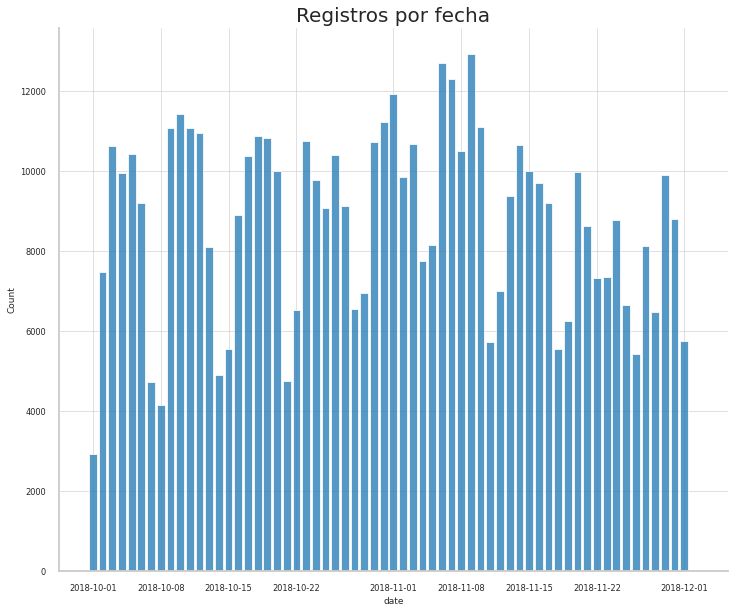

In [ ]:
#Visualización de cómo se distribuyen los registros en el tiempo
plt.figure(figsize=(12,10))
fig = sns.histplot(clients_activity_churn.date, discrete=True, shrink=.8)
fig.set_title("Registros por fecha", fontsize=20)
sns.despine()

Observamos que el uso de la plataforma decae los fines de semana. Fuera de estas variaciones entre semana, en general el nivel de uso se mantiene constante en octubre, aumenta un poco la primera semana de noviembre y luego decae levemente. 

### Registros por Usuario

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



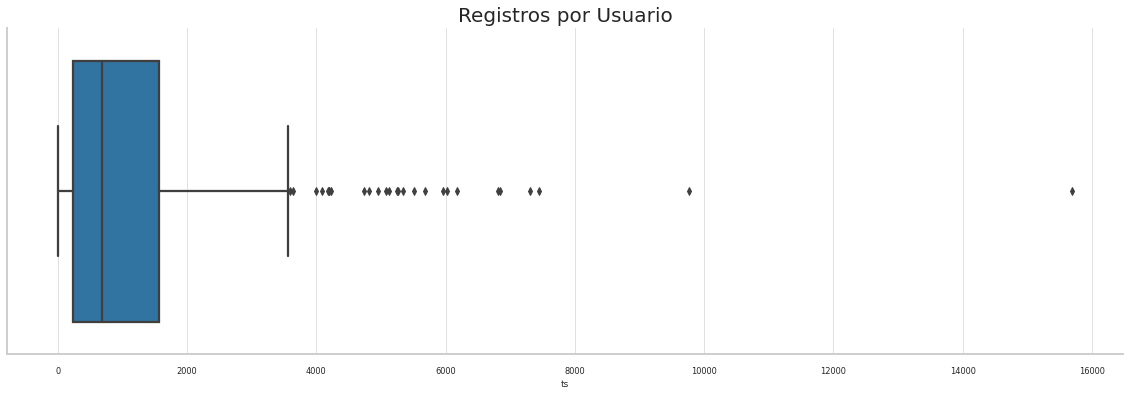

In [ ]:
#Visualización de Cantidad de registros por usuario

plt.figure(figsize=(20,6))
fig = sns.boxplot(clients_activity_churn.groupby('userId').count().reset_index().ts);
fig.set_title("Registros por Usuario", fontsize=20)
sns.despine()

In [ ]:
#Vemos algunos datos estadisticos sobre la cantidad de registros por usuario
clients_activity_churn.groupby('userId').count().reset_index().ts.describe()

count     449.000
mean     1210.924
std      1539.976
min         3.000
25%       229.000
50%       692.000
75%      1568.000
max     15700.000
Name: ts, dtype: float64

Observamos que la mayoría de los usuarios realizaron entre 229 y 1568 interacciones con la plataforma en este periodo de tiempo. 

Aquí identificamos algunos usuarios particulares, que tienen interacciones muy bajas (como el usuario que solo realizó 3) y otros que tienen un gran volumen de interacciones, como el usuario que realizó 15.700 interacciones con la plataforma en el periodo de tiempo analizado.

### Datos Nulos y faltantes

En el apartado anterior (punto 1.d), observamos que hay dos tipos de datos nulos, a nivel canción y a nivel datos de usuario. Por otro lado, observamos que hay variables, como userId, que tienen datos faltantes "en cubierto". 

## Punto c: Balance de Clases

Una vez definido “Churn”, ¿las clases están balanceadas? (¿Hay más usuarios que hacen churn que los que no o viceversa?).

In [ ]:
#Cantidad de usuarios churn vs no churn
clients_activity_churn.groupby('userId', as_index=False).agg({'churn_user': 'first'})['churn_user'].value_counts()

0    350
1     99
Name: churn_user, dtype: int64

Observamos que hay más usuarios que No hacen churn que los que sí hacen churn. El siguiente gráfico nos muestra la proporción que cada clase representa del total

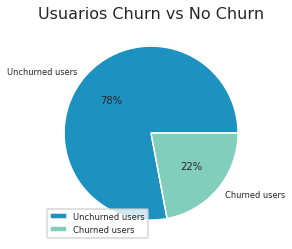

In [ ]:
#Grafico de torta para analizar las clases Churn vs No Churn

palette = [small_palette[2],small_palette[4]]

#Armamos el gráfico
plt.pie(clients_activity_churn.groupby('userId', as_index=False).agg({'churn_user': 'first'})['churn_user'].value_counts(), 
          labels=['Unchurned users', 'Churned users'], colors= palette, autopct='%.0f%%');

plt.title("Usuarios Churn vs No Churn", size = 16);
plt.legend(loc='lower left', prop={'size':'small'});
plt.show()

## Punto d: Usuarios churn vs no churn

Comparar el comportamiento de los “usuarios churn” vs “usuarios no churn” en términos de:


1. Uso a diferentes horas del día
2. Uso en diferentes días de la semana
3. Nivel de usuario (gratuito o pago)
4. Tipos de eventos (por ejemplo, añadir un amigo, publicidad, pulgares
arriba)
5. Dispositivo utilizado (por ejemplo, Mac, Windows, iPhone)
6. Ubicación del usuario (por ejemplo, Nueva Inglaterra, Pacífico)
7. Tiempo transcurrido desde la baja (downgrade) hasta el abandono
(Cancellation Confirmation).
8. ¿Cuál es la distribución de los usuarios por género?
9. ¿Cuáles usuarios escucharon más canciones?
10. ¿Dónde se encuentra el mayor número de usuarios del servicio?
11. ¿Cuántos artistas y canciones únicos tiene el conjunto de datos?
12. ¿Cuáles son las canciones y artistas más populares?
13. ¿Cómo es la relación de ambos grupos (churn vs no churn) con la
page == 'Error'?
14. Página más visitada
15. Analice las interacciones con la página “Help” por “userId” y por
‘sessionId’.

Como vamos a comparar el comportamiento de los usuarios que hicieron chur vs los que no hicieron churn, vamos a separar el df en dos:

In [ ]:
is_churn = clients_activity_churn['churn_user'] == 1

churn_df = clients_activity_churn[is_churn] #df where users are churn
not_churn_df = clients_activity_churn[~is_churn] #df where users are NOT churn

### Uso de las diferentes horas del dia



La hora del dia en que se realiza cada interacción está reflejada en la columna `'hour'`

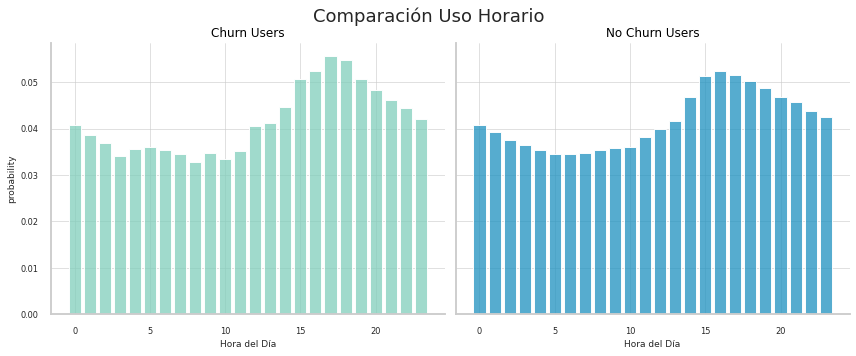

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True);
fig.suptitle('Comparación Uso Horario', size = 18) #Titulo para la figura

#Grafico Usuarios Churn
churn = sns.histplot(churn_df.hour, discrete=True, color = color_churn,
                      shrink=.8, stat="probability", ax = axes[0]);

churn.set_title("Churn Users", size=12, color='black');

#Grafico Usuarios No Churn
not_churn = sns.histplot(not_churn_df.hour, discrete=True, shrink=.8, stat="probability",
                        color = color_no_churn, ax = axes[1]);

not_churn.set_title("No Churn Users", size=12, color='black');

for ax in axes.flat:
    ax.set(xlabel='Hora del Día', ylabel='probability') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

Observamos que en general ambas clases tienden a utilizar más la plataforma en el horario de la tarde, siendo esta tendencia levemente más fuerte en los usuarios que hicieron churn. 

###Uso en diferentes días de la semana

La información sobre los días de la semana en los que ocurre cada transacción está reflejada en la columna `'day'`

In [ ]:
#Agregamos una columna weekday para poder ver los dias con nombres
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
churn_df.loc[:,'weekday'] = churn_df['day'].map(dayOfWeek)
not_churn_df.loc[:,'weekday'] = not_churn_df['day'].map(dayOfWeek)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
churn_df[['day','weekday']].value_counts().sort_index()

day  weekday  
0    Monday       15606
1    Tuesday      18595
2    Wednesday    16185
3    Thursday     17731
4    Friday       16142
5    Saturday     10499
6    Sunday        8888
dtype: int64

In [ ]:
not_churn_df[['day','weekday']].value_counts().sort_index()

day  weekday  
0    Monday       67455
1    Tuesday      71175
2    Wednesday    73765
3    Thursday     75040
4    Friday       74581
5    Saturday     46458
6    Sunday       31585
dtype: int64

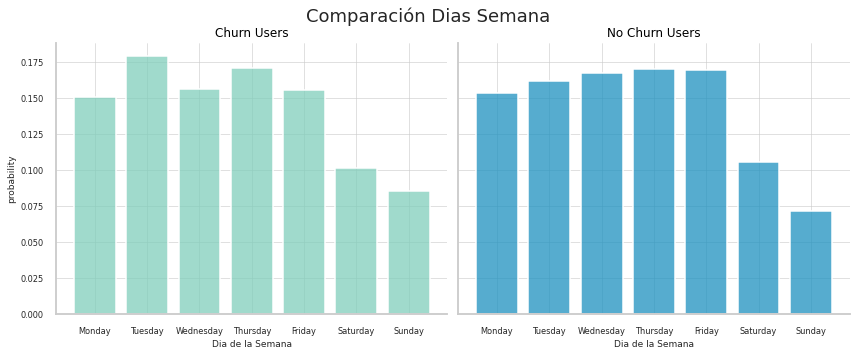

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True);
fig.suptitle('Comparación Dias Semana', size = 18) #Titulo para la figura

#Grafico Usuarios Churn
churn = sns.histplot(churn_df.weekday, discrete=True, shrink=.8, stat="probability",
                        color = color_churn, ax = axes[0]);

churn.set_title("Churn Users", size=12, color='black');

#Grafico Usuarios No Churn
not_churn = sns.histplot(not_churn_df.weekday, discrete=True, shrink=.8, stat="probability",
                        color = color_no_churn, ax = axes[1]);

not_churn.set_title("No Churn Users", size=12, color='black');

for ax in axes.flat:
    ax.set(xlabel='Dia de la Semana', ylabel='probability') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

Los usuarios no churn hace un uso más parejo durante los días de la semana, con una leve tendencia a aumentar a medida que se acerca el viernes. Mientras que en los usuario churn el uso durante la semana es mayor los martes y jueves. 

En ambos casos el uso se reduce durante los fines de semana. Sin embargo, notamos que los usuarios churn usan un poco más la plataforma los domingos que los usuarios no churn. 

### Nivel de usuario (gratuito o pago)

El nivel de usuario se ve reflejado en la columna `'level'`.

In [ ]:
#cantidad de usuarios churn pagos vs no pagos
churn_df.groupby('userId', as_index=False).agg({'level': 'first'})['level'].value_counts()

free    73
paid    26
Name: level, dtype: int64

In [ ]:
#cantidad de usuarios no churn pagos vs no pagos
not_churn_df.groupby('userId', as_index=False).agg({'level': 'first'})['level'].value_counts()

free    269
paid     81
Name: level, dtype: int64

- De los 99 usuarios churn, 73 usaban la plataforma de manera gratuita y 26 de manera paga. 

- De los 350 usuarios no churn, 269 usan la plataforma de manera gratuita y 81 de manera paga. 

En el siguiente gráfico se muestra la proporción para cada clase. Observamos que la proporción de usuarios gratuitos es levemente mayor en los usuarios No churn:

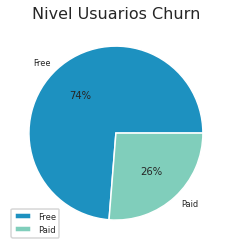

In [ ]:
palette = [small_palette[2],small_palette[4]]

#Gráfico para los usuarios churn
plt.pie(churn_df.groupby('userId', as_index=False).agg({'level': 'first'})['level'].value_counts(), 
          labels=['Free', 'Paid'], colors= palette, autopct='%.0f%%');

plt.title("Nivel Usuarios Churn", size = 16);
plt.legend(loc='lower left', prop={'size':'small'});
plt.show()

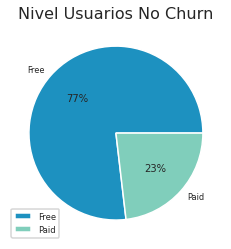

In [ ]:
#Gráfico para los usuarios No churn
plt.pie(not_churn_df.groupby('userId', as_index=False).agg({'level': 'first'})['level'].value_counts(), 
          labels=['Free', 'Paid'], colors= palette, autopct='%.0f%%');

plt.title("Nivel Usuarios No Churn", size = 16);
plt.legend(loc='lower left', prop={'size':'small'});
plt.show()

### Tipos de eventos (por ejemplo, añadir un amigo, publicidad, pulgares arriba)

Para comparar los tipos de eventos entre ambos grupos exploramos entre los valores que tiene la columna `page`.

#### Comparación a nivel registro

In [ ]:
#Usamos value_counts() para ver cuántos registros efectuó cada clase para cada tipo de evento:
churn_df.page.value_counts() 

NextSong                     84359
Thumbs Up                     4300
Home                          3778
Add to Playlist               2259
Roll Advert                   2186
Add Friend                    1537
Logout                        1184
Thumbs Down                   1156
Downgrade                      831
Settings                       619
Help                           517
Upgrade                        237
About                          185
Save Settings                  104
Cancel                          99
Cancellation Confirmation       99
Error                           97
Submit Upgrade                  70
Submit Downgrade                29
Name: page, dtype: int64

In [ ]:
not_churn_df.page.value_counts()

NextSong               348518
Home                    23634
Thumbs Up               19526
Add to Playlist         10090
Add Friend               6550
Login                    6011
Roll Advert              5587
Logout                   4806
Thumbs Down              3755
Downgrade                2980
Help                     2633
Settings                 2345
About                    1670
Upgrade                   731
Save Settings             481
Error                     422
Submit Upgrade            217
Submit Downgrade           88
Register                   11
Submit Registration         4
Name: page, dtype: int64

In [ ]:
# Seleccionamos algunos eventos interesantes a comparar
interesting_events = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Roll Advert', 'Add Friend', 'Error', 'Submit Upgrade', 'Submit Downgrade'] 

#### Comparación a nivel usuario

Calculamos cuantos usuarios de cada clase realizaron cada evento

In [ ]:
#Para usuarios que hicieron churn:
churn_events = churn_df[churn_df.page.isin(interesting_events)]
churn_events = churn_events.groupby('userId', as_index=False).agg({'page': 'first'})['page'].value_counts(normalize=True)
churn_events

Roll Advert       0.364
Thumbs Up         0.323
Add to Playlist   0.111
Add Friend        0.101
Thumbs Down       0.081
Submit Upgrade    0.010
Error             0.010
Name: page, dtype: float64

In [ ]:
#Para usuarios No churn:
not_churn_events = not_churn_df[not_churn_df.page.isin(interesting_events)]
not_churn_events = not_churn_events.groupby('userId', as_index=False).agg({'page': 'first'})['page'].value_counts(normalize=True)
not_churn_events

Thumbs Up          0.330
Roll Advert        0.302
Add to Playlist    0.147
Add Friend         0.132
Thumbs Down        0.066
Submit Upgrade     0.011
Error              0.009
Submit Downgrade   0.003
Name: page, dtype: float64

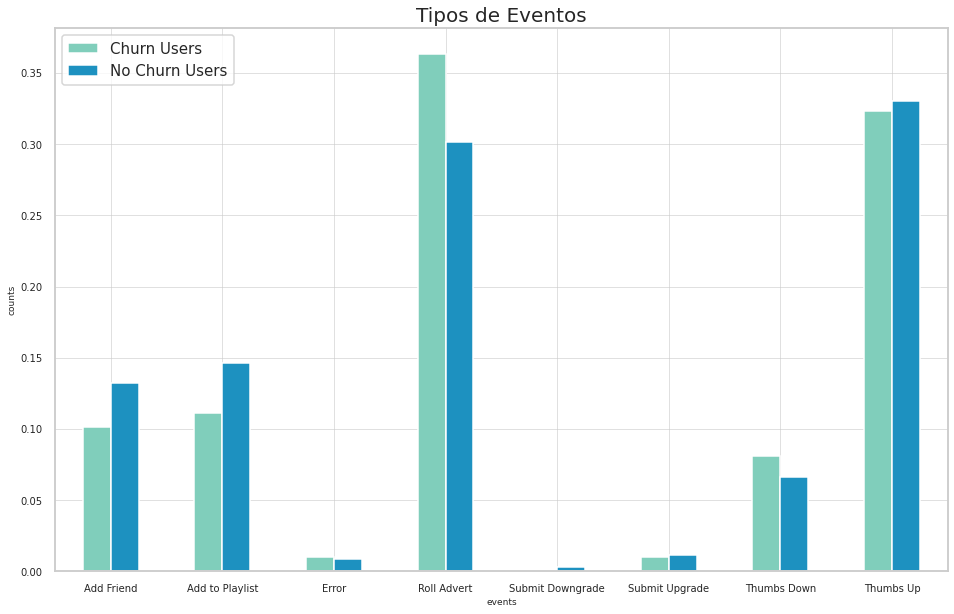

In [ ]:
#Gráficamente

df = pd.DataFrame({"Churn Users":churn_events,"No Churn Users":not_churn_events})
ax = df.plot(kind="bar", rot=0, color=[color_churn, color_no_churn], figsize=(16,10), fontsize=10)
ax.legend(loc=2, prop={'size': 15})
ax.set_title("Tipos de Eventos", fontsize=20)
ax.set_xlabel("events")
ax.set_ylabel("counts")
plt.show()

Observamos que los usuarios que hacen churn vieron una mayor cantidad de publicidades que los usuarios que no hicieron churn. Además, tuvieron mayor interacción con el boton thumbs down, que refleja que no les gustó una canción, artista o algo de la plataforma. 

En cambio, aquellos que no hicieron churn tuvieron una mayor cantidad de interacciones positivas, como agregar un amigo, agregar una canción a la cola y ponerle me gusta a alguna canción. 

### Dispositivo utilizado

Para comparar los dispositivos utilizados por los grupos exploramos los valores de la columna `userAgent`

In [ ]:
#Hacemos un vistazo de los dispositivos utilizados por usuarios churn

churn_df.groupby('userId', as_index=False).agg({'userAgent': 'first'})['userAgent'].value_counts()

Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       11
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                         7
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                      6
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                      6
"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"     6
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                 5
Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko                                                        

In [ ]:
#Dispositivos usados por usuarios No churn

not_churn_df.groupby('userId', as_index=False).agg({'userAgent': 'first'})['userAgent'].value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                35
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       23
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     19
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"                        19
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                17
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"     

####Proceso de limpieza de la columna userAgent

Observamos que los datos en este formato resultan dificiles de interpretar. Para ello, procedemos a limpiar los datos. 

In [ ]:
#Instalamos la libreris user-agents
!pip install user-agents

In [ ]:
#Importamos un parser para usar con esta libreria
from ua_parser import user_agent_parser

In [ ]:
# Para los churn agrupo por userId la columna userAgent y aplico user_agent_parser

parsed_churn_agent = churn_df.groupby('userId', as_index=False).agg({'userAgent': 'first'})['userAgent'].apply(user_agent_parser.Parse)

In [ ]:
#creamos un nuevo df con los datos
parsed_churn_ua = pd.io.json.json_normalize(parsed_churn_agent)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [ ]:
#el df resultante es:
parsed_churn_ua[:3]

,string,user_agent.family,user_agent.major,user_agent.minor,user_agent.patch,os.family,os.major,os.minor,os.patch,os.patch_minor,device.family,device.brand,device.model
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Chrome,36,0,1985,Mac OS X,10,9,4,None,Mac,Apple,Mac
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",Chrome,36,0,1985,Mac OS X,10,6,8,None,Mac,Apple,Mac
2,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Firefox,31,0,None,Windows,7,None,None,None,Other,None,None


In [ ]:
#Me quedo con la columna os.family que es la que me interesa contar y comparar
#Vamos a normalizar los datos porque cada clase tienen cantidades distintas de usuarios

parsed_churn_ua = parsed_churn_ua['os.family'].value_counts(normalize=True) 
parsed_churn_ua

Windows    0.485
Mac OS X   0.354
iOS        0.111
Ubuntu     0.030
Linux      0.020
Name: os.family, dtype: float64

In [ ]:
# En el caso de los NO CHURN, por algun motivo, tenemos que convertir la columna userAgent a string
not_churn_df['userAgent']=not_churn_df['userAgent'].apply(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Mismo proceso para los NO churn
parsed_nochurn_agent = not_churn_df.groupby('userId', as_index=False).agg({'userAgent': 'first'})['userAgent'].apply(user_agent_parser.Parse)
parsed_nochurn_ua = pd.io.json.json_normalize(parsed_nochurn_agent)
parsed_nochurn_ua['os.family'].value_counts(normalize=True) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Windows    0.497
Mac OS X   0.394
iOS        0.046
Ubuntu     0.031
Linux      0.029
Other      0.003
Name: os.family, dtype: float64

In [ ]:
#Acá tenemos una nueva categoría 'Other' que no tiene un volumen significativo, así que la sacamos

#Obtengo una lista de los indices de las filas que quiero eliminar
index = parsed_nochurn_ua.index
other_mask = parsed_nochurn_ua['os.family'] == 'Other' 
index_drop = index[other_mask].tolist()

#Aplico el metodo drop
parsed_nochurn_ua.drop(index = index_drop, axis = 0, inplace = True)

In [ ]:
#Aplico value_counts()
parsed_nochurn_count = parsed_nochurn_ua['os.family'].value_counts(normalize=True)
parsed_nochurn_count 

Windows    0.499
Mac OS X   0.395
iOS        0.046
Ubuntu     0.032
Linux      0.029
Name: os.family, dtype: float64

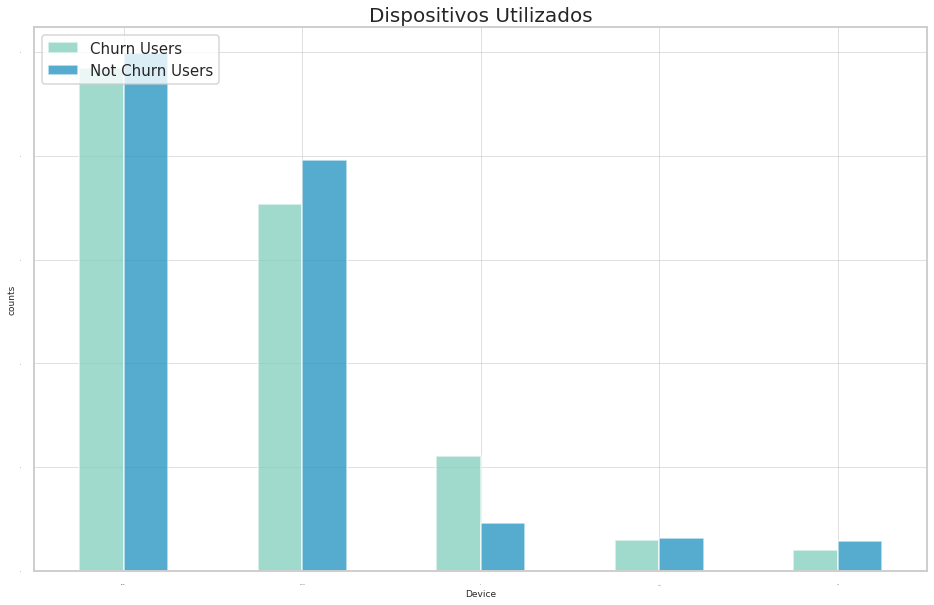

In [ ]:
# cortar other
# Linux y Ubuntu los diferencia
df = pd.DataFrame({"Churn Users":parsed_churn_ua,"Not Churn Users":parsed_nochurn_count}) 
ax = df.plot(kind="bar", rot=0, alpha=0.75, figsize=(16,10), fontsize=1, color =[color_churn, color_no_churn])
ax.legend(loc=2, prop={'size': 15})
ax.set_title("Dispositivos Utilizados", fontsize=20)
ax.set_xlabel("Device")
ax.set_ylabel("counts")
plt.show()

Observamos que los usuarios que en ambos casos, son más los usuarios que utilizan 'windows' o 'mac'; pero que, en los usuarios que usan 'ios' tiene mayor peso la clase churn. 

### ¿Dónde se encuentra el mayor número de usuarios del servicio?

La ubicación de los usuarios se ve reflejada en la columna `'location'`

In [ ]:
#La columna location tiene nombres de ciudades seguida por nombres de estados abreviados, el país es Estados Unidos.
not_churn_df.groupby('userId', as_index=False).agg({'location': 'first'})['location'].value_counts()[:3]

Los Angeles-Long Beach-Anaheim, CA       23
New York-Newark-Jersey City, NY-NJ-PA    22
Chicago-Naperville-Elgin, IL-IN-WI       12
Name: location, dtype: int64

In [ ]:
#Armamos una pequeña función para que en una columna aparte nos muestre solamente las siglas de los estados para luego poder visualizar el estado con mayor número de usuarios.
import re

def split_location(location_str):
  if not isinstance(location_str, str):
    return None
  try:
    state = re.search(".+,(.+)", location_str).group(1)
    return state
  except AttributeError:
    state = None
    return state

In [ ]:
#aplicamos la función al df de los usuarios churn
churn_df.loc[:, 'estado'] = churn_df.location.apply(split_location)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#aplicamos la función al df de los usuarios no churn
not_churn_df.loc[:, 'estado'] = not_churn_df.location.apply(split_location)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Nos fijamos cuál es el estado más popular entre los usuarios que no hacen churn
not_churn_df.groupby('userId', as_index=False).agg({'estado': 'first'})['estado'].value_counts(normalize=True)[:3]

 CA         0.149
 TX         0.089
 NY-NJ-PA   0.063
Name: estado, dtype: float64

In [ ]:
#Nos fijamos cuál es el estado más popular entre los usuarios que hacen churn
churn_df.groupby('userId', as_index=False).agg({'estado': 'first'})['estado'].value_counts(normalize=True)[:3]

 CA         0.101
 NY-NJ-PA   0.081
 IL-IN-WI   0.071
Name: estado, dtype: float64

Podemos conlcuir que en ambos casos (usuarios Churn vs usuarios Not Churn) el estado con mas usuarios es California; donde pertenecen el 14% de los usuarios de la clase no churn y el 10% de los de la clase churn.

### Ubicación del usuario

**Tabla de Frecuencias**

1.   Comparamos frecuencia de población entre los distintos estados utilizando la nueva columna agregada 'estados' para ambos grupos
2.   Utilizamos **valores relativos** al tener distintas cantidades
3.  Se realiza corte en **0,02** (inclusive) dejando el 1 % de estados fuera de la comparación

In [ ]:
churn_df_estados = churn_df.groupby('userId', as_index=False).agg({'estado': 'first'})['estado'].value_counts(normalize=True)

In [ ]:
notchurn_df_estados = not_churn_df.groupby('userId', as_index=False).agg({'estado': 'first'})['estado'].value_counts(normalize=True)

In [ ]:
df_estados = pd.DataFrame({"Churn Users":churn_df_estados,"No Churn Users":notchurn_df_estados}) 
df_estados = df_estados[(df_estados['Churn Users'] >= 0.02) & (df_estados['No Churn Users'] >= 0.02)] # cortamos
df_estados = df_estados.sort_values(by=['Churn Users', 'No Churn Users'], ascending=False) # ordenamos por mayor frecuencia
df_estados

,Churn Users,No Churn Users
CA,0.101,0.149
NY-NJ-PA,0.081,0.063
IL-IN-WI,0.071,0.034
FL,0.061,0.057
TX,0.051,0.089
GA,0.040,0.023
MI,0.030,0.023
AZ,0.020,0.023
IN,0.020,0.023
WA,0.020,0.023


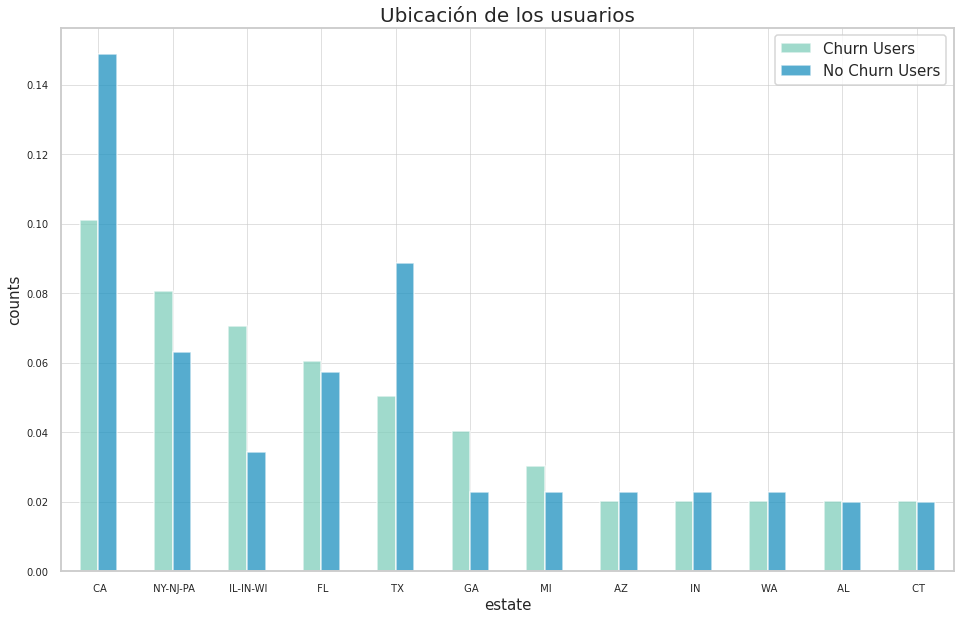

In [ ]:
#Visualización de la locación de los usuarios
ax = df_estados.plot(kind="bar", rot=0, alpha=0.75, color=[color_churn, color_no_churn], figsize=(16,10), fontsize=10)
ax.legend(loc=1, prop={'size': 15}) #loc=1 ordena la posicion del legend
ax.set_title("Ubicación de los usuarios", fontsize=20)
ax.set_xlabel("estate", fontsize=15)
ax.set_ylabel("counts", fontsize=15)
plt.show()

Observamos que California **(CA)** es donde se encuentran la mayor cantidad de usuarios estando un **10%** de usuarios que han hecho churn y un **14,9%** de usuarios que no han hecho churn seguido por Área metropolitana de Nueva York **(NY-NJ-PA)** donde se encuentran un **8%** de usuarios churn y **6%** de usuarios que no han hecho churn.

Las diferencias más notables se encuentran en los estados de Texas **(TX)**, donde hay una fuerte presencia de usuarios no churn en comparación con los churn y en el area metropolitana de Chicago **(IL-IN-WI)**, donde la relación es la opuesta. 

### Tiempo transcurrido desde la baja hasta el abandono

Analizaremos las columnas `Downgrade` y `Cancellation Confirmation`

In [ ]:
#Veamos cuántos usuarios pasaron a descender un nivel:
downgrade_users = clients_activity_churn[clients_activity_churn.page == 'Downgrade'].userId.unique()
print("Cantidad de usuarios que hicieron Downgrade: ", len(downgrade_users)) 

Cantidad de usuarios que hicieron Downgrade:  301


In [ ]:
#Veamos cuántos registros hay en la intersección de ellos con los que hacen Cancellation Confirmation.
cancellation_users = clients_activity_churn[clients_activity_churn.page == 'Cancellation Confirmation'].userId.unique()
print("Cantidad de usuarios que hicieron Cancellation Confirmation: ", len(cancellation_users))

Cantidad de usuarios que hicieron Cancellation Confirmation:  99


In [ ]:
intersection_users = np.intersect1d(downgrade_users, cancellation_users)
len(intersection_users)

74

In [ ]:
# Armo un df con solo los registros para esos usuarios. Es más simple trabajar con menos datos
reduced_df = clients_activity_churn[
                                    (clients_activity_churn.userId.isin(intersection_users)) & 
                                    ((clients_activity_churn.page == 'Downgrade') | 
                                    (clients_activity_churn.page == 'Cancellation Confirmation'))]
reduced_df[:3]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,artist,song,length,date,hour,day,month,year,churn_action,churn_user
565,1538363510,246,245,Downgrade,Logged In,GET,200,paid,85,"Mobile, AL",...,NaN,NaN,NaN,2018-10-01 03:11:50,3,0,10,2018,False,1
1116,1538372836,246,245,Downgrade,Logged In,GET,200,paid,131,"Mobile, AL",...,NaN,NaN,NaN,2018-10-01 05:47:16,5,0,10,2018,False,1
1374,1538376155,18,476,Downgrade,Logged In,GET,200,paid,34,"Kansas City, MO-KS",...,NaN,NaN,NaN,2018-10-01 06:42:35,6,0,10,2018,False,1


In [ ]:
#Para cada usuario nos fijamos cuándo fue la última vez que realizó cada acción:
reduced_df = reduced_df.groupby(['userId', 'page']).agg({'ts': 'max'})
reduced_df[:3]

ts
userId page                                 
10     Cancellation Confirmation  1539055364
       Downgrade                  1538969557
100003 Cancellation Confirmation  1541661592

In [ ]:
#Calculamos la diferencia entre cada una de las acciones:
import functools

def time_diff(s):
  return functools.reduce(lambda a, b: a-b, s)

users_time_df = reduced_df.groupby(['userId']).agg({'ts': time_diff})
users_time_df[:3]

,ts
userId,
10,85807
100003,108165
100011,34


In [ ]:
#Se convierte la diferencia de 'ts' a horas,minutos,segundos
users_time_df.loc[:,'horas'] = users_time_df.ts // (60 * 60)
users_time_df.loc[:,'min'] = (users_time_df.ts // (60)) % 60
users_time_df.loc[:,'seg'] = users_time_df.ts % 60

In [ ]:
users_time_df[:3]

,ts,horas,min,seg
userId,,,,
10,85807,23,50,7
100003,108165,30,2,45
100011,34,0,0,34


In [ ]:
#Vemos las medidas estadísticas de esta información:
users_time_df.describe()

,ts,horas,min,seg
count,74.000,74.000,74.000,74.000
mean,184345.338,51.014,11.176,26.149
std,465176.018,129.155,18.232,18.850
min,1.000,0.000,0.000,1.000
25%,33.250,0.000,0.000,10.000
50%,107.000,0.000,1.000,21.500
75%,72703.250,19.750,16.000,41.750
max,1999046.000,555.000,56.000,59.000


Existe una gran dispersión entre los tiempos. La media es de 50 hs aproximadamente pero la mediana está cerca de los 2 minutos. Esto tiene que ver con el valor máximo de horas que se registró en algún evento (555 horas)

In [ ]:
users_time_df.columns

Index(['ts', 'horas', 'min', 'seg'], dtype='object')

Visualmente, podemos observar como varía la frecuencia de las horas transcurridas entre una acción y la otra mediante el siguiente gráfico:

Text(0.5, 1.0, 'Tiempo transcurrido desde la baja hasta el abandono')

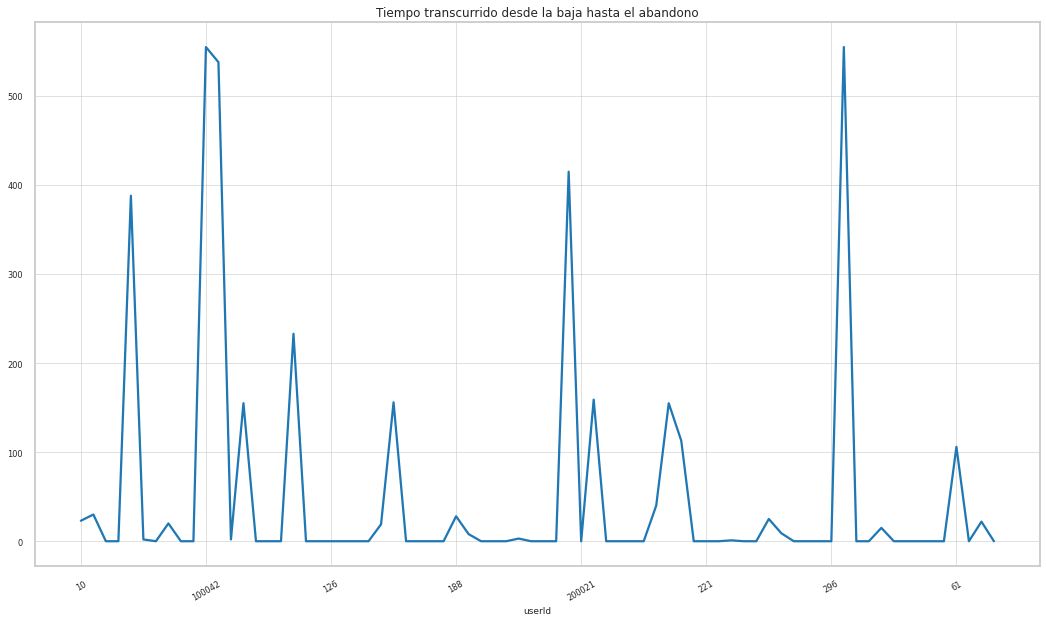

In [ ]:
users_time_df['horas'].plot(kind='line', figsize=(18,10), rot=30)
plt.title("Tiempo transcurrido desde la baja hasta el abandono",fontsize= 12)

### Distribución de los usuarios por género

La columna que nos muestra la información de los usuarios por genero es `'gender'`. 

In [ ]:
churn_df.groupby('userId', as_index=False).agg({'gender': 'first'})['gender'].value_counts()

M    54
F    45
Name: gender, dtype: int64

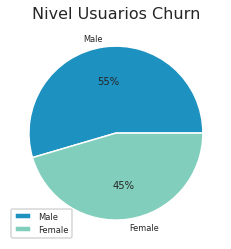

In [ ]:
#Gráfico para los usuarios churn
plt.pie(churn_df.groupby('userId', as_index=False).agg({'gender': 'first'})['gender'].value_counts(), 
          labels=['Male', 'Female'], colors= palette, autopct='%.0f%%');

plt.title("Nivel Usuarios Churn", size = 16);
plt.legend(loc='lower left', prop={'size':'small'});
plt.show()

De los 99 usuarios churn, el 55% (54 personas), son hombres y el 45% mujeres

In [ ]:
not_churn_df.groupby('userId', as_index=False).agg({'gender': 'first'})['gender'].value_counts()

M    196
F    153
Name: gender, dtype: int64

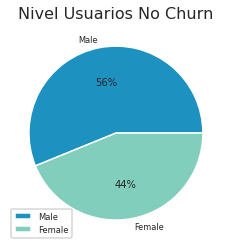

In [ ]:
#Gráfico para los usuarios churn
plt.pie(not_churn_df.groupby('userId', as_index=False).agg({'gender': 'first'})['gender'].value_counts(), 
          labels=['Male', 'Female'], colors= palette, autopct='%.0f%%');

plt.title("Nivel Usuarios No Churn", size = 16);
plt.legend(loc='lower left', prop={'size':'small'});
plt.show()

A partir del análisis de estos gráficos de torta se puede observar que en principio NO hay diferencia de distribución de géneros entre los usuarios Churn vs los usuarios Not Churn (en ambos se ve que hay aprox un 55%, 56% hombres y un 45%, 44% de mujeres). No es una variable correlativa a la variable target.

### ¿Cuáles usuarios escucharon más canciones?


Para contabilizar las cantidades de veces que se reproducen canciones nos fijamos en la columna `'page'` específicamente en el campo "NextSong" tanto para los usuarios Churn como para los usuarios Not Churn.

In [ ]:
#Usuarios churn
is_nextsong_churn = churn_df['page'] == 'NextSong' #Mascara Next Song
churn_df[is_nextsong_churn].userId.count() #Contamos la cantidad de veces que la clase hace esta interación
churn_df[is_nextsong_churn].userId.count()

84359

In [ ]:
#Usuarios NOT churn
is_nextsong_not_churn = not_churn_df['page'] == 'NextSong' #Mascara Next Song
not_churn_df[is_nextsong_not_churn].userId.count() #Contamos la cantidad de veces que la clase hace esta interación

348518

In [ ]:
#Cantidad de veces que un usuario puntual de la clase churn escuchó una canción
churn_song_count_df = churn_df[is_nextsong_churn].userId.value_counts().rename_axis('userId').reset_index(name='counts')
churn_song_count_df[:3]

,userId,counts
0,140,6233
1,18,4640
2,293,4246


In [ ]:
#medidas estadisticas para esas cantidades
churn_song_count_df.describe()

,counts
count,99.000
mean,852.111
std,1054.788
min,7.000
25%,164.500
50%,439.000
75%,1243.500
max,6233.000


In [ ]:
#cantidad de veces que un usuario puntual de la clase no churn escuchó una canción
not_churn_song_count_df = not_churn_df[is_nextsong_not_churn].userId.value_counts().rename_axis('userId').reset_index(name='counts')
not_churn_song_count_df[:3]

,userId,counts
0,92,8177
1,300049,5879
2,101,5745


In [ ]:
#medidas estadisticas para esas cantidades
not_churn_song_count_df.describe()

,counts
count,349.000
mean,998.619
std,1176.055
min,1.000
25%,196.000
50%,601.000
75%,1316.000
max,8177.000


En conclusión, observamos que mientras la cantidad promedio de canciones que escucha un usuario de la clase churn es 852, para la clase no churn esto es de 998. 

Además, observamos que el 50% de los usuarios de la clase churn escuchó más de 439 canciones en estos dos meses, mientras que el 50% de los usuarios de la clase not churn escuchó más de 601 canciones en este mismo periodo de tiempo. De esta manera, concluimos que en generar la clase no churn hace un uso más intensivo de esta plataforma para escuchar canciones.

### ¿Cuántos artistas y canciones únicos tiene el conjunto de datos?


In [ ]:
print('total de canciones únicas:')

#canciones unicas en total
print('para el total usuarios', clients_activity_churn.song.nunique())

#canciones unicas para el conjunto no churn
print('para el usuarios no churn', not_churn_df.song.nunique())

#canciones unicas para el conjunto churn
print('para el usuarios churn', churn_df.song.nunique())

total de canciones únicas:
para el total usuarios 80292
para el usuarios no churn 72419
para el usuarios churn 33143


In [ ]:
print('total de artistas únicas:')

#canciones unicas en total
print('para el total usuarios', clients_activity_churn.artist.nunique())

#canciones unicas para el conjunto no churn
print('para el usuarios no churn', not_churn_df.artist.nunique())

#canciones unicas para el conjunto churn
print('para el usuarios churn', churn_df.artist.nunique())

total de artistas únicas:
para el total usuarios 21247
para el usuarios no churn 19992
para el usuarios churn 12151


Notamos que en general la clase not churn escucha una mayor variedad de artistas y canciones que la clase churn. 

### ¿Cuáles son las canciones y artistas más populares?

In [ ]:
#Para cada artista cuantos usuarios churn los escucharon alguna vez
churn_df.groupby('userId', as_index=False).agg({'artist': 'first'})['artist'].value_counts()[:3]

Evanescence    3
Linkin Park    2
Eminem         2
Name: artist, dtype: int64

In [ ]:
#Para cada artista cuantos usuarios no churn los escucharon alguna vez
not_churn_df.groupby('userId', as_index=False).agg({'artist': 'first'})['artist'].value_counts()[:3]

Nickelback       5
Kings Of Leon    4
Coldplay         3
Name: artist, dtype: int64

In [ ]:
#Para cada cancion cuantos usuarios churn los escucharon alguna vez
churn_df.groupby('userId', as_index=False).agg({'song': 'first'})['song'].value_counts()[:3]

Bring Me To Life                                              2
Stronger                                                      2
You Dont Know What Love Is (You Just Do What Youre Told)    1
Name: song, dtype: int64

In [ ]:
#Para cada cancion cuantos usuarios no churn los escucharon alguna vez
not_churn_df.groupby('userId', as_index=False).agg({'song': 'first'})['song'].value_counts()[:3]

Revelry           4
Greece 2000       3
You're The One    2
Name: song, dtype: int64

###¿Cómo es la relación de ambos grupos (churn vs no churn) con la page == 'Error'?


In [ ]:
# Armo unos df que contengan sólo las page de error
error_not_churn = not_churn_df[not_churn_df['page'] == "Error"]
error_churn = churn_df[churn_df['page'] == "Error"]

In [ ]:
# Calculo la cantidad de veces que cada usuario interactua con la pagina Error
grouped_error_not_churn = error_not_churn.groupby('userId', as_index=False).agg({'page':'count'})

# Calculo la media de veces que un usuario no_churn tiene interacciones con la pagina de error durante todo el tiempo cubierto por el data set
grouped_error_not_churn.page.mean()

2.2934782608695654

In [ ]:
#Se realiza el mismo procedimiento al anterior pero para los usuarios churn
grouped_error_churn = error_churn.groupby('userId', as_index=False).agg({'page':'count'})
grouped_error_churn.page.mean()

2.425

Se puede ver que **la media de veces que un usuario tiene un mensaje de error es superior para los usuarios que hicieron churn**. 

Esta puede ser una variable interesante para calcular la correlación en el punto siguiente.

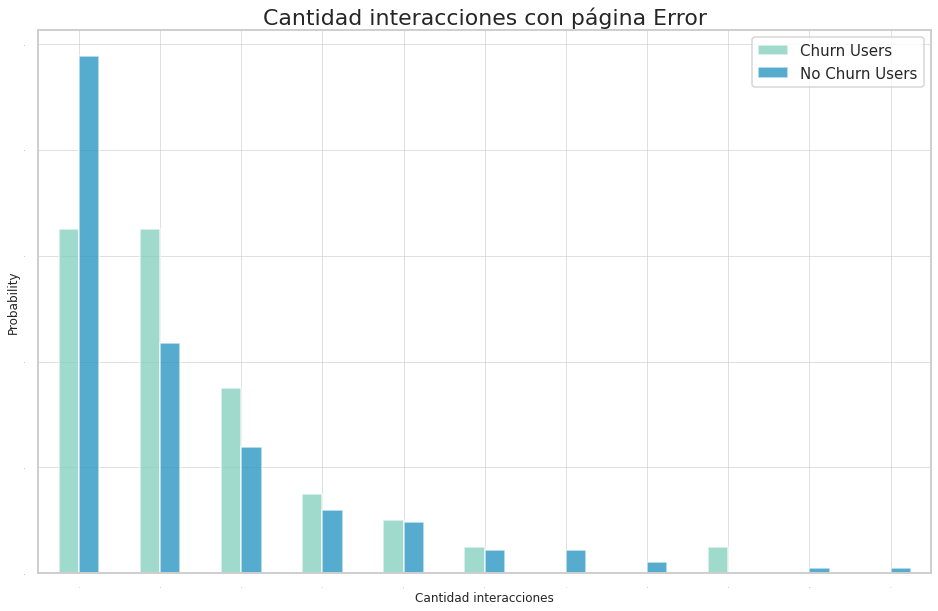

In [ ]:
#Gráfico para comparar cómo son las interacciones con la página error para cada clase
error_df = pd.DataFrame(
              {"Churn Users":grouped_error_churn.page.value_counts(normalize=True),
                "No Churn Users":grouped_error_not_churn.page.value_counts(normalize=True)}
                )


fig = error_df.plot(kind="bar", rot=0, alpha=0.75, figsize=(16,10), fontsize=1, color =[color_churn, color_no_churn])
fig.legend(loc=1, prop={'size': 15})
fig.set_title("Cantidad interacciones con página Error", fontsize=22)
fig.set_xlabel("Cantidad interacciones",fontsize=12)
fig.set_ylabel("Probability",fontsize=12)
plt.show()

Observamos que a medida que aumenta la cantidad de interacciones aumenta la frecuencia para los usuarios de la clase churn

###Página más visitada


In [ ]:
churn_df['page'].value_counts(normalize=True).sort_values(ascending=False)

NextSong                    0.814
Thumbs Up                   0.041
Home                        0.036
Add to Playlist             0.022
Roll Advert                 0.021
Add Friend                  0.015
Logout                      0.011
Thumbs Down                 0.011
Downgrade                   0.008
Settings                    0.006
Help                        0.005
Upgrade                     0.002
About                       0.002
Save Settings               0.001
Cancel                      0.001
Cancellation Confirmation   0.001
Error                       0.001
Submit Upgrade              0.001
Submit Downgrade            0.000
Name: page, dtype: float64

In [ ]:
not_churn_df['page'].value_counts(normalize=True).sort_values(ascending=False)

NextSong              0.792
Home                  0.054
Thumbs Up             0.044
Add to Playlist       0.023
Add Friend            0.015
Login                 0.014
Roll Advert           0.013
Logout                0.011
Thumbs Down           0.009
Downgrade             0.007
Help                  0.006
Settings              0.005
About                 0.004
Upgrade               0.002
Save Settings         0.001
Error                 0.001
Submit Upgrade        0.000
Submit Downgrade      0.000
Register              0.000
Submit Registration   0.000
Name: page, dtype: float64

Notamos que en general, el orden de las páginas más visitadas en similar en ambos grupos, por lo tanto no parece ser información útil para diferenciar estas dos clases de usuarios.

La única diferencia notable es que en el caso de los usuarios churn la página "Roll Advert" figura en el top 5, y en el caso de los usuarios No churn, no.

###Analice las interacciones con la página “Help” por “userId” y por ‘sessionId’.

In [ ]:
# Cantidad de usuarios Churn que tuvieron interacción con la página help
churn_df[churn_df['page'] == 'Help'].groupby('userId')['page'].value_counts().shape

(81,)

In [ ]:
# Media de veces por usuario churn que interaccionan con la página help
churn_df[churn_df['page'] == 'Help'].groupby('userId')['page'].count().reset_index().mean()

userId     inf
page     6.383
dtype: float64

In [ ]:
# Cantidad de usuarios No churn que tuvieron interacción con la página help
not_churn_df[not_churn_df['page'] == 'Help'].groupby('userId')['page'].value_counts().shape

(280,)

In [ ]:
# Media de veces por usuario que interaccionan con la página help
not_churn_df[(not_churn_df['page'] == 'Help') & (not_churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index().mean()

userId     inf
page     7.624
dtype: float64

Observamos que en promedio, los usuarios churn interactúan menos con la página Help

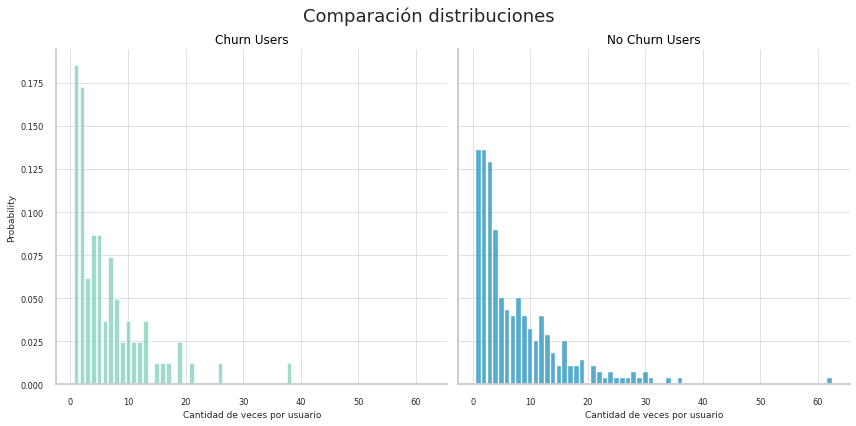

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6),sharey=True, sharex=True);
fig.suptitle('Comparación distribuciones', size = 18)

#Grafico Usuarios Churn
churn = sns.histplot(churn_df[(churn_df['page'] == 'Help') & (churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index().page, 
                      discrete=True, shrink=.8, color = color_churn, ax = axes[0], stat = 'probability');

churn.set_title("Churn Users", size=12, color='black');

#Grafico Usuarios No Churn
not_churn = sns.histplot(not_churn_df[(not_churn_df['page'] == 'Help') & (not_churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index().page, 
                          discrete=True, shrink=.8, color = color_no_churn, ax = axes[1], stat = 'probability');

not_churn.set_title("No Churn Users", size=12, color='black');

for ax in axes.flat:
    ax.set(xlabel='Cantidad de veces por usuario') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

La media de veces que se consulta a la pagina Help es mayor para los usuarios que no hicieron churn, pero las distribuciones son muy parecidas en ambos grupos

In [ ]:
# Cantidad de sesiones en las que hubo interacción con la página help
churn_df[churn_df['page'] == 'Help'].groupby('sessionId')['page'].value_counts().shape

(332,)

In [ ]:
not_churn_df[not_churn_df['page'] == 'Help'].groupby('sessionId')['page'].value_counts().shape

(1544,)

In [ ]:
# Media de veces por sesion que interaccionan con la página help
not_churn_df[(not_churn_df['page'] == 'Help') & (not_churn_df['sessionId'] != '')].groupby('sessionId')['page'].count().reset_index().mean()

sessionId   2116.728
page           1.705
dtype: float64

In [ ]:
churn_df[churn_df['page'] == 'Help'].groupby('sessionId')['page'].count().reset_index().mean()

sessionId   1732.633
page           1.557
dtype: float64

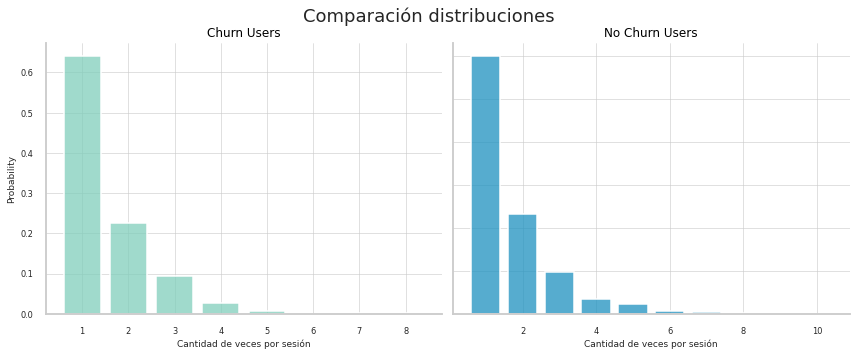

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5));
fig.suptitle('Comparación distribuciones', size = 18)

#Grafico Usuarios Churn
churn = sns.histplot(churn_df[(churn_df['page'] == 'Help') & (churn_df['sessionId'] != '')].groupby('sessionId')['page'].count().reset_index().page, 
                      discrete=True, shrink=.8, stat = 'probability', color = color_churn, ax = axes[0]);

churn.set_title("Churn Users", size=12, color='black');

#Grafico Usuarios No Churn
not_churn = sns.histplot(not_churn_df[(not_churn_df['page'] == 'Help') & (not_churn_df['sessionId'] != '')].groupby('sessionId')['page'].count().reset_index().page, 
                         discrete=True, shrink=.8, stat = 'probability', color = color_no_churn, ax = axes[1]);

not_churn.set_title("No Churn Users", size=12, color='black');

for ax in axes.flat:
    ax.set(xlabel='Cantidad de veces por sesión') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

De nuevo, para las sesiones sucede algo similar a lo que se vió con los userId, las distribuciones son muy parecidas entre ambos grupos. Lo cual nos indicaría que no es un valor muy interesante para analizar.

### Extra: Análisis de la cantidad de sesiones por usuario

Comparamos la cantidad promedio y la mediana de sesiones que incian los usuarios entre las clases

In [ ]:
#Media de sesiones para usuarios no churn
session_user_nochurn = clients_activity_churn[clients_activity_churn['churn_user'] == 0].groupby(['userId', 'churn_user'])['sessionId'].unique().reset_index()
session_user_nochurn.sessionId = session_user_nochurn.sessionId.str.len()
session_user_nochurn.sessionId.mean()

22.974285714285713

In [ ]:
#Mediana de sesiones para usuarios no churn
session_user_nochurn.sessionId.median()

10.0

In [ ]:
#Media de sesiones para usuarios churn
session_user_churn = clients_activity_churn[clients_activity_churn['churn_user'] == 1].groupby(['userId', 'churn_user'])['sessionId'].unique().reset_index()
session_user_churn.sessionId = session_user_churn.sessionId.str.len()
session_user_churn.sessionId.mean()

12.090909090909092

In [ ]:
#Mediana de sesiones para usuarios churn
session_user_churn.sessionId.median()

8.0

Notamos que los usuarios no churn tienen valores mas altos en la media y la mediana que los churn. 

Veamos graficamente como se distribuyen los usuarios en función de la cantidad de sesiones que inicia.

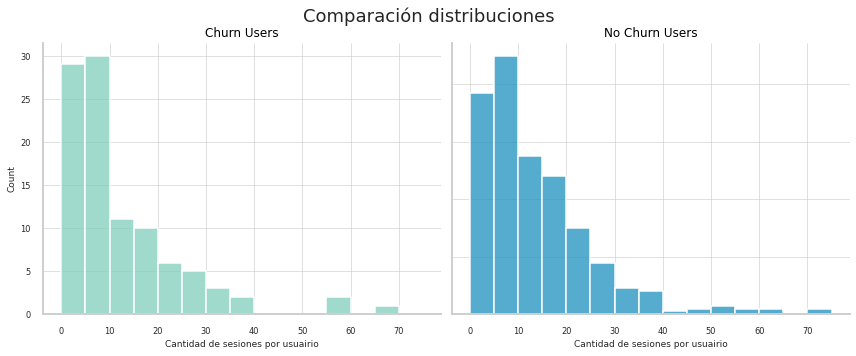

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5));
fig.suptitle('Comparación distribuciones', size = 18)

#Grafico Usuarios Churn
churn = sns.histplot(session_user_churn.sessionId, bins=range(0,80,5), 
                      color = color_churn, ax = axes[0]);

churn.set_title("Churn Users", size=12, color='black');

#Grafico Usuarios No Churn
not_churn = sns.histplot(session_user_nochurn.sessionId, bins=range(0,80,5),
                          color = color_no_churn, ax = axes[1]);

not_churn.set_title("No Churn Users", size=12, color='black');

for ax in axes.flat:
    ax.set(xlabel='Cantidad de sesiones por usuairio') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

Graficamente, no se observa una diferencia considerable entre ambas clases.

## Punto e: Correlación con la variable target

En base a los puntos anteriores analice la correlación entre las variables y la variable target.

### Variable Level

Cuando estudiamos la composición de las clases en terminos de tipo de usuario, notamos que ambas tenian aproximadamente un 75% de usuarios gratuitos. 

In [ ]:
churn_users = clients_activity_churn[clients_activity_churn['churn_user'] == 1].groupby('userId')
not_churn_users = clients_activity_churn[clients_activity_churn['churn_user'] == 0].groupby('userId')
users = clients_activity_churn.groupby('userId')

In [ ]:
#Probabilidad de ser churn
prob_churn = len(churn_users) / len(users)
prob_churn

0.22048997772828507

In [ ]:
#Probabilidad de ser no churn
prob_not_churn = len(not_churn_users) / len(users)
prob_not_churn

0.779510022271715

In [ ]:
#Probabilidad de ser gratuito

free_user = clients_activity_churn[clients_activity_churn['level'] == 'free'].groupby('userId')
prob_free = len(free_user) / len(users)
prob_free

0.8262806236080178

In [ ]:
#Probabilidad de ser churn y gratuito

churn_free_users = clients_activity_churn[(clients_activity_churn['level'] == 'free') & (clients_activity_churn['churn_user'] == 1)].groupby('userId')
prob_free_churn = len(churn_free_users) / len(users)

prob_free_churn

0.18262806236080179

In [ ]:
#Probabilidad de ser churn dado que soy gratuito

prob_cond_free_churn = prob_free_churn / prob_free
prob_cond_free_churn

0.22102425876010784

In [ ]:
#Diferencia entre las probabilidades de ser churn y de ser churn dado que sy gratuito
dif = prob_churn - prob_cond_free_churn
dif

-0.0005342810318227642

In [ ]:
#Probabilidad de ser pago

paid_user = clients_activity_churn[clients_activity_churn['level'] == 'paid'].groupby('userId')
prob_paid = len(paid_user) / len(users)

#Probabilidad de ser churn y pago

churn_paid_users = clients_activity_churn[(clients_activity_churn['level'] == 'paid') & (clients_activity_churn['churn_user'] == 1)].groupby('userId')
prob_paid_churn = len(churn_paid_users) / len(users)

#Probabilidad de ser churn dado que soy pago

prob_cond_paid_churn = prob_paid_churn / prob_paid
prob_cond_paid_churn

0.2329192546583851

In [ ]:
dif = prob_churn - prob_cond_paid_churn
dif

-0.012429276930100014

Notamos que ser gratuito o pago no aumenta considerablemente las proabilidades de ser churn, por lo que podemos decir que la correlación entre la variable level y la variable target es más bien debil.

### Variable Horas y Dias de la semana

Cuando observamos las horas del dia en la que usaban la plataforma los usuarios churn y no churn, observamos que no había mayores diferencias. Algo similar nos ocurrió cuando estudiamos los días de la semana

De esta manera, cocluimos que no hay correlación entre estas variables y la variable target

### Variable Page

La variable page nos muestra con que pagina interactua el usuario en cada registro. En este sentido, encontramos que hay correlación entre la variable Page y la variable target ya que la interacción con algunas de las distintas paginas están relacionadas con mayor fuerza a la variable churn.

####Correlación con la Pagina Error

Notamos, en primer lugar, que para la proporción de usuarios que interactuan con la pagina Error para usuarios churn es mayor a la proporción de usuarios churnque si interactuan con esta pagina. Mientras que para los no churn es al revés. 

In [ ]:
#Armo un df con los usuarios que alguna vez vieron la pag erro y la cantidad de veces que la vieron
error_churn = churn_df[(churn_df['page'] == 'Error') & (churn_df['userId'] != '')].groupby('userId').count().reset_index().userId.tolist()
error_churn_df = churn_df[(churn_df['page'] == 'Error') & (churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index()

#Armo un df con los usuarios que nunca vieron la pag erro
no_error_churn = churn_df[~churn_df['userId'].isin(error_churn)].groupby('userId').count().reset_index().userId.tolist()
no_error_churn_df = pd.DataFrame({'userId':no_error_churn,'page':0})

#Los uno
error_count_churn = error_churn_df.append(no_error_churn_df, ignore_index = True)

In [ ]:
#cantidad de usuarios churn que nunca interactuan con la pagina error vs los que si
print('si interactua', error_churn_df.page.count())
print('no interactua', no_error_churn_df.page.count())

si interactua 40
no interactua 59


In [ ]:
#Armo un df con los usuarios que alguna vez vieron la pag erro y la cantidad de veces que la vieron
error_not_churn = not_churn_df[(not_churn_df['page'] == 'Error') & (not_churn_df['userId'] != '')].groupby('userId').count().reset_index().userId.tolist()
error_not_churn_df = not_churn_df[(not_churn_df['page'] == 'Error') & (not_churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index()

#Armo un df con los usuarios que nunca vieron la pag erro
no_error_not_churn = not_churn_df[~not_churn_df['userId'].isin(error_not_churn)].groupby('userId').count().reset_index().userId.tolist()
no_error_not_churn_df = pd.DataFrame({'userId':no_error_not_churn,'page':0})

#Los uno
error_count_not_churn = error_not_churn_df.append(no_error_not_churn_df, ignore_index = True)

In [ ]:
#cantidad de usuarios no churn que nunca interactuan con la pagina error vs los que si
print('si interactua', error_not_churn_df.page.count())
print('no interactua', no_error_not_churn_df.page.count())

si interactua 183
no interactua 167


Por otro lado, dado un usuario que interactua con la pagina Error, observamos graficamente que al aumentar la cantidad de interacciones con la pagina, hay más presencia de usuarios churn; mientras que la presencia de no churn se disminuye .

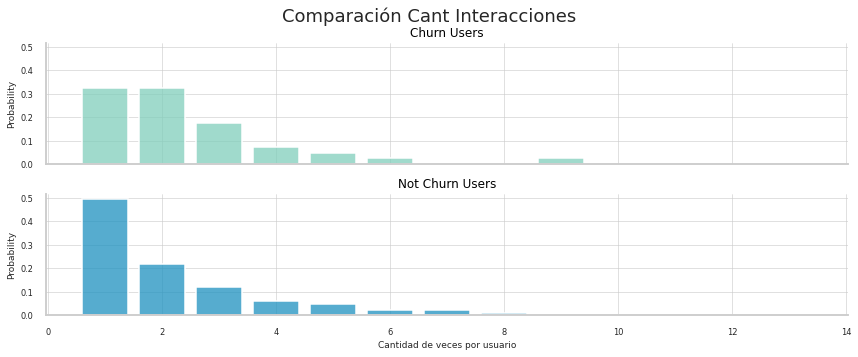

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 5),sharey=True,sharex=True);
fig.suptitle('Comparación Cant Interacciones', size = 18)

#Grafico Usuarios Churn
churn = sns.histplot(churn_df[(churn_df['page'] == 'Error') & (churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index().page, 
                      discrete=True, shrink=.8, color = color_churn, ax = axes[0], stat = 'probability');

churn.set_title("Churn Users", size=12, color='black');

#Grafico Usuarios No Churn
not_churn = sns.histplot(not_churn_df[(not_churn_df['page'] == 'Error') & (not_churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index().page, 
                          discrete=True, shrink=.8, color = color_no_churn, ax = axes[1], stat = 'probability');

not_churn.set_title("Not Churn Users", size=12, color='black');

for ax in axes.flat:
    ax.set(xlabel='Cantidad de veces por usuario') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

#### Correlación con la Cantidad de Anuncios que ven

La cantidad de anuncios que ve un usuario tiene una correlación con la variable churn; la mayoria de los usuarios churn ven más anuncios que la mayoria de los usuarios No churn.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



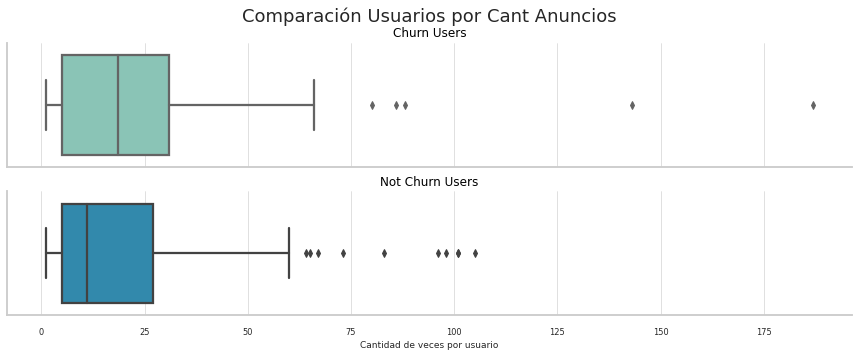

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 5),sharex=True);
fig.suptitle('Comparación Usuarios por Cant Anuncios', size = 18)

#Grafico Usuarios Churn
churn = sns.boxplot(churn_df[(churn_df['page'] == 'Roll Advert') & (churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index().page,
                      color = color_churn, ax = axes[0]);

churn.set_title("Churn Users", size=12, color='black');

#Grafico Usuarios No Churn
not_churn = sns.boxplot(not_churn_df[(not_churn_df['page'] == 'Roll Advert') & (not_churn_df['userId'] != '')].groupby('userId')['page'].count().reset_index().page, 
                          color = color_no_churn, ax = axes[1]);

not_churn.set_title("Not Churn Users", size=12, color='black');

for ax in axes.flat:
    ax.set(xlabel='Cantidad de veces por usuario') #Set axes name
    ax.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

# Agregamos tight layout y espaciamos los titulos de manera acorde
fig.tight_layout()
fig.subplots_adjust(top=0.88)
sns.despine()

#### Correlación con otros eventos

Además de lo mencionado anteriormente, cuando analizamos los tipos de eventos, habíamos notados que los usuarios no churn suelen interactuar con mayor frecuencia con las paginas `Thumbs Up`, `Add to Playlist`, `Add Friend`. Mientras que los usuarios que hacen churn interactuan con mayor frecuencia con la pagina `Thumbs Down`.

### Variable Dispositivo

Cuando estudiamos los dispositivos y sistemas operativos que utiliza cada usuario, observamos que en los usuarios que usan ios, hay una mayor proporción de usuarios churn; mientras que en los que usan Mac había una mayor proporción de no churn. 



### Canciones y Artistas

Al analizar las variables song y artists descubrimos que los usuarios no churn escuchan una mayor cantidad de canciones que los usuarios churn. Y que además, escuchan una mayor variedad de canciones y artistas que esta otra clase. Por lo que podriamos suponer que la variable tienen correlación con la variable target.

## Punto f: Tiempo de vida del cliente

Analice el tiempo que pasa entre que un usuario se registra y es considerado “churn” (eventos 'Cancellation Confirmation' o 'Submit Downgrade'), calcule la media y mediana en cantidad de días.

In [ ]:
#Observamos que no hay filas donde el momento de registrarse sea cero

clients_activity_churn[clients_activity_churn['registration']==0]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,artist,song,length,date,hour,day,month,year,churn_action,churn_user


In [ ]:
#Notamos que si tenemos datos para los que registration es nula
clients_activity_churn[clients_activity_churn['registration'].isna()].userId.count()

15700

In [ ]:
#Sacamos estos puntos del analisis
reg_df = clients_activity_churn[~clients_activity_churn['registration'].isna()]

In [ ]:
import datetime
import numpy as np

def convert_reg(df, timestamp_column):
  df[timestamp_column] = df[timestamp_column]/1000.0
  df[timestamp_column] = df[timestamp_column].apply(np.int64)
  # unit='s' to convert it into epoch time
  df['reg_date']=pd.to_datetime(df[timestamp_column], unit='s')
  #Convert datetime column/series to hour of the day. NB: Column must be in datetime format.
  df['reg_hour'] = df['reg_date'].dt.hour
  #Convert datetime column/series to day of the week
  df['reg_day'] = df['reg_date'].dt.weekday
  #Convert datetime column/series to month
  df['reg_month'] = df['reg_date'].dt.month
  #Convert datetime column/series to year
  df['reg_year'] = df['reg_date'].dt.year
  return df

In [ ]:
#Usamos la función que habiamos creado en el punto 1.c
clients_reg = convert_reg(df=reg_df, timestamp_column='registration')

In [ ]:
#Queremos ver solo a los registros donde ocurre la accion churn
index_names = clients_reg[clients_reg['page']!='Cancellation Confirmation'].index
clients_reg.drop(index_names , inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
clients_reg[:3]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,day,month,year,churn_action,churn_user,reg_date,reg_hour,reg_day,reg_month,reg_year
2555,1538400616,208,490,Cancellation Confirmation,Cancelled,GET,200,free,40,"Fort Wayne, IN",...,0,10,2018,True,1,2018-09-12 13:20:39,13,2,9,2018
6758,1538482793,231,471,Cancellation Confirmation,Cancelled,GET,200,paid,234,"Columbus, OH",...,1,10,2018,True,1,2018-08-05 12:38:20,12,6,8,2018
12652,1538539871,236,682,Cancellation Confirmation,Cancelled,GET,200,paid,109,"Grand Rapids-Wyoming, MI",...,2,10,2018,True,1,2018-06-26 06:46:19,6,1,6,2018


In [ ]:
#Calculamos para cada usuario los dias transcurridos entre la fecha de registracción y la fecha churn
clients_reg["dias_transcurridos"] = (clients_reg["date"] - clients_reg["reg_date"]).dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
clients_reg[['userId',"reg_date","date","dias_transcurridos"]][:3]

,userId,reg_date,date,dias_transcurridos
2555,208,2018-09-12 13:20:39,2018-10-01 13:30:16,19
6758,231,2018-08-05 12:38:20,2018-10-02 12:19:53,57
12652,236,2018-06-26 06:46:19,2018-10-03 04:11:11,98


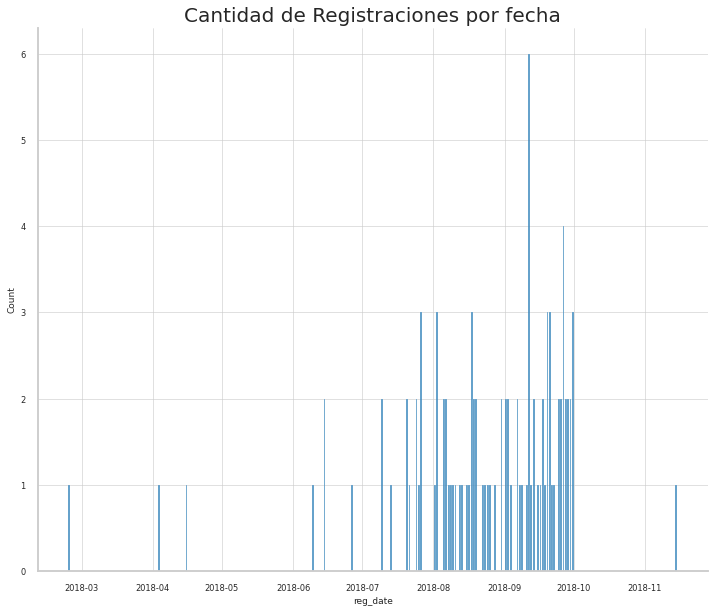

In [ ]:
#Como se distribuyen las registraciones en el tiempo
plt.figure(figsize=(12,10))
fig = sns.histplot(clients_reg.reg_date, discrete=True, shrink=.8)
fig.set_title("Cantidad de Registraciones por fecha", fontsize=20)
sns.despine()

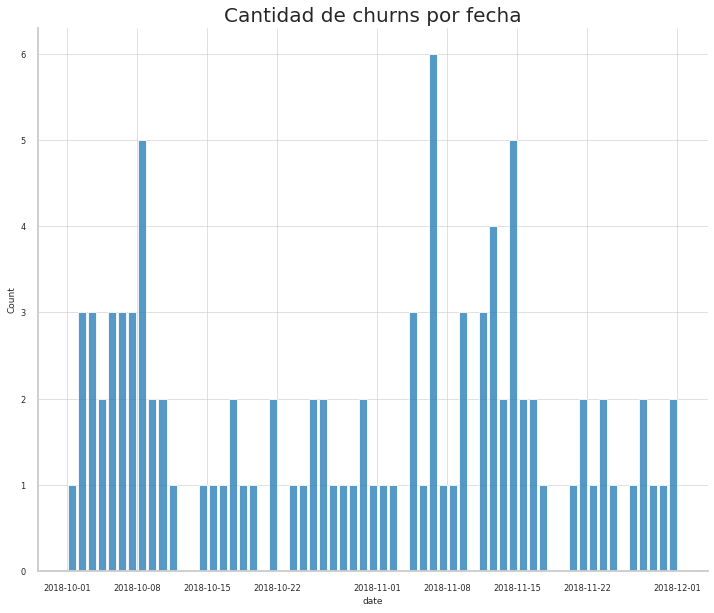

In [ ]:
#Como se distribuyen las acciones churn en el tiempo
plt.figure(figsize=(12,10))
fig = sns.histplot(clients_reg.date, discrete=True, shrink=.8)
fig.set_title("Cantidad de churns por fecha", fontsize=20)
sns.despine()

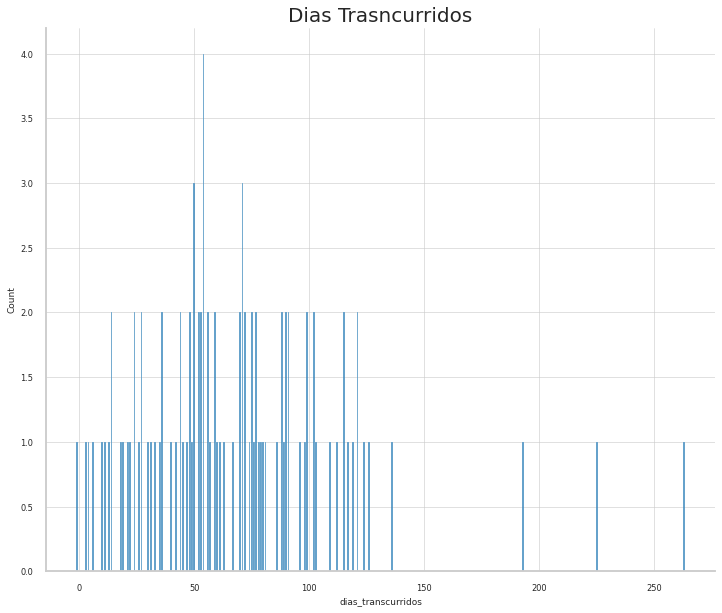

In [ ]:
#Como se distribuyen las frecuencias de las distancias en el tiempo entre una acción y la otra
plt.figure(figsize=(12,10))
fig = sns.histplot(clients_reg.dias_transcurridos, discrete=True, shrink=.8)
fig.set_title("Dias Trasncurridos", fontsize=20)
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



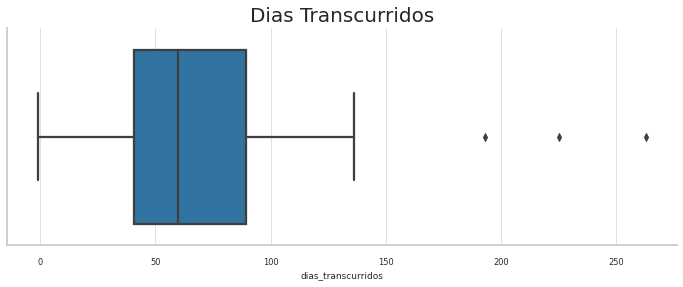

In [ ]:
#Como se distribuyen las frecuencias de las distancias en el tiempo entre una acción y la otr
plt.figure(figsize=(12,4))
fig = sns.boxplot(clients_reg.dias_transcurridos);
fig.set_title("Dias Transcurridos", fontsize=20)
sns.despine()

In [ ]:
clients_reg.dias_transcurridos.describe()

count    99.000
mean     67.485
std      43.532
min      -1.000
25%      41.000
50%      60.000
75%      89.500
max     263.000
Name: dias_transcurridos, dtype: float64

Notamos que en promedio, un usuario churn utiliza la plataforma por 67 dias antes de abandonar. La mayoria de los usuarios churn permanece en la plataforma entre 41 y 89 dias.

## Punto g: Definir columnas interesantes

¿Cuáles columnas resultan “interesantes” para ser incluídas en un futuro modelo predictivo de churn? (Debieran ser aquellas que presentan cierto comportamiento diferente para los usuarios churn o no churn).

En función del analisis realizado anteriormente, definimos las siguientes columnas como interesantes:

* `UserId`:Porque nos interesa conocer el comporamiento a nivel usuario.
* `Page`: Los distintos eventos con los que interactua el usuario y la frecuencia con la que lo hace esta correlacionada con la variable target. 
* `Song` y `Artist`: La frecuencia con la que un individuo escucha musica y la variedad de canciones y artistas que escuche esta correlacionado con la variable target. 
* `Level`: Si bien no encontramos una fuerte correlación entre esta variable level y la variable target, creemos que si es interesante mantener esta variable en el analisis ya que es interesante saber si un usuario que va a hacer churn es o no pago. 
* `SessionId`: Nos muestra cuantas veces un individuo inicia sesión. En el apartado extra notamos que en promedio, esto es mayor para los usuarios churn, por lo que podríamos asumir que hay una correlación entre esta variable y la variable target. 
* `ts` y `date`: Si bien no encontramos correlaciones entre el dia de la semana o la hora en que el individuo utiliza la plataforma. Creemos que estudiar como cambian las interacciones del usuario en el tiempo es importante para poder hacer predicciones sobre su comportamiento futuro; por lo que decidimos incluir estas columnas dentro de nuestro conjunto interesante. 
* `registration` y `reg_date`: nos brinda información de la etapa del ciclo de vida en la que se encuentra el usuario. 

Además, incluimos entre nuestras columnas interesantes a la columna target, `churn_user`, que nos indica si el usuario canceló o no su suscripción en algun momento. 





In [ ]:
interesting_cols = ['userId','page','song','artist','level','sessionId','ts','date','registration','reg_date','churn_user']

In [ ]:
#Guardamos un archivo con nuestro df con unicamente las columnas que nos interesan
clients_activity_churn[interesting_cols].to_csv('churn_interesting_cols.csv',index=False)